In [0]:
# for coloab only
from google.colab import drive
drive.mount('/content/gdrive')
root_dir = '/content/gdrive/My Drive/CE - ML &Deep Learning/Machine Learning/Lab 4'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# ตอนที่ 1: การทดลองเตรียมข้อมูลและแสดงรายละเอียดข้อมูลเชิงกราฟ

### Import Lib (numpy, pandas, matplotlib, sklearn, keras)

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans 
from sklearn.mixture import GaussianMixture

import re

plt.style.use('ggplot')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### โหลดข้อมูล

In [0]:
rating_df = pd.read_csv(root_dir + '/ratings.csv')
movie_df = pd.read_csv(root_dir + '/movies.csv')
tag_df = pd.read_csv(root_dir + '/tags.csv')

### Data Preprocessing

In [0]:
rating_df['uts'] = pd.to_datetime(rating_df['timestamp'], unit='s', origin=pd.Timestamp('1970-01-01'))
rating_df['year'] = rating_df['uts'].apply(lambda uts : uts.year)
rating_df

,userId,movieId,rating,timestamp,uts,year
0,1,1,4.0,964982703,2000-07-30 18:45:03,2000
1,1,3,4.0,964981247,2000-07-30 18:20:47,2000
2,1,6,4.0,964982224,2000-07-30 18:37:04,2000
3,1,47,5.0,964983815,2000-07-30 19:03:35,2000
4,1,50,5.0,964982931,2000-07-30 18:48:51,2000
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,2017-05-03 21:53:22,2017
100832,610,168248,5.0,1493850091,2017-05-03 22:21:31,2017
100833,610,168250,5.0,1494273047,2017-05-08 19:50:47,2017
100834,610,168252,5.0,1493846352,2017-05-03 21:19:12,2017


In [0]:
tag_df['uts'] = pd.to_datetime(tag_df['timestamp'], unit='s', origin=pd.Timestamp('1970-01-01'))
tag_df

,userId,movieId,tag,timestamp,uts
0,2,60756,funny,1445714994,2015-10-24 19:29:54
1,2,60756,Highly quotable,1445714996,2015-10-24 19:29:56
2,2,60756,will ferrell,1445714992,2015-10-24 19:29:52
3,2,89774,Boxing story,1445715207,2015-10-24 19:33:27
4,2,89774,MMA,1445715200,2015-10-24 19:33:20
...,...,...,...,...,...
3678,606,7382,for katie,1171234019,2007-02-11 22:46:59
3679,606,7936,austere,1173392334,2007-03-08 22:18:54
3680,610,3265,gun fu,1493843984,2017-05-03 20:39:44
3681,610,3265,heroic bloodshed,1493843978,2017-05-03 20:39:38


In [0]:
movie_df['year'] = movie_df['title'].str.extract(r"\((\d+)\)")
movie_df['year'] .fillna(method='ffill', inplace=True)              # เติมค่า null value(year) ด้วย ปีก่อนหน้า
movie_df['year'] = movie_df['year'].astype('int32')                 # cast to integer

movie_df['year'] = movie_df.apply(lambda row: row['title'].strip()[-5:-1] if row['year'] < 1800 else row['year'], axis=1)
movie_df['year'] = movie_df['year'].astype('int32')                 # cast to integer

movie_df.describe()

,movieId,year
count,9742.000000,9742.000000
mean,42200.353623,1994.628105
std,52160.494854,18.539042
min,1.000000,1902.000000
25%,3248.250000,1988.000000
50%,7300.000000,1999.000000
75%,76232.000000,2008.000000
max,193609.000000,2018.000000


In [0]:
# Create list of genre dataframe 
temp_genre = movie_df.copy()
temp_genre['genres_split'] = temp_genre['genres'].str.split(pat = "|")
temp_genre = temp_genre[['movieId', 'genres_split']]
temp_genre.columns = ['movieId', 'genres']
temp_genre

# Iterate each row to find unique genre
genre_set = set()
for index, row in temp_genre.iterrows():
  [genre_set.add(g) for g in row['genres']]
  
# Create genre dataframe 
genre_df = pd.DataFrame(index=temp_genre.index, columns=genre_set)
genre_df['movieId']  = temp_genre['movieId']

for index, row in temp_genre.iterrows():
  for genre in row['genres']:
    genre_df.loc[index, genre] = 1 

genre_df.fillna(0, inplace=True)
new_column = ['movieId'] + (genre_df.columns[: -1].tolist())
genre_df = genre_df[new_column]
genre_df.index.name = 'No.'
genre_df

,movieId,Comedy,Drama,Western,(no genres listed),Crime,Action,Mystery,Children,Thriller,Musical,Adventure,War,Animation,Fantasy,IMAX,Sci-Fi,Film-Noir,Romance,Documentary,Horror
No.,,,,,,,,,,,,,,,,,,,,,
0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0
2,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0
9738,193583,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
9739,193585,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Data Visualization

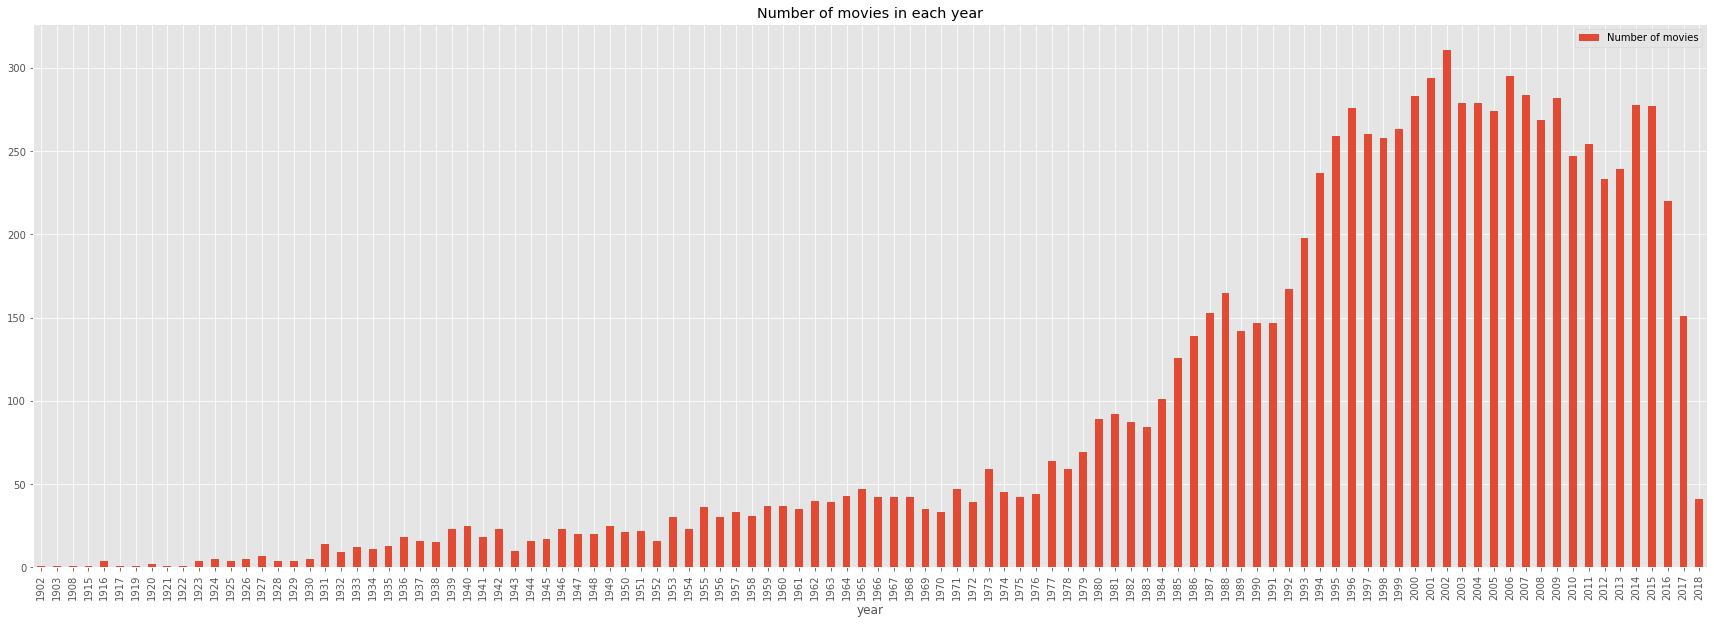

In [0]:
#  จำนวน released movies ในแต่ละปี
release_movie = movie_df[['year', 'movieId']].groupby(['year']).count()
release_movie.columns = ['Number of movies']
release_movie.plot.bar(figsize=(30,10), title='Number of movies in each year')

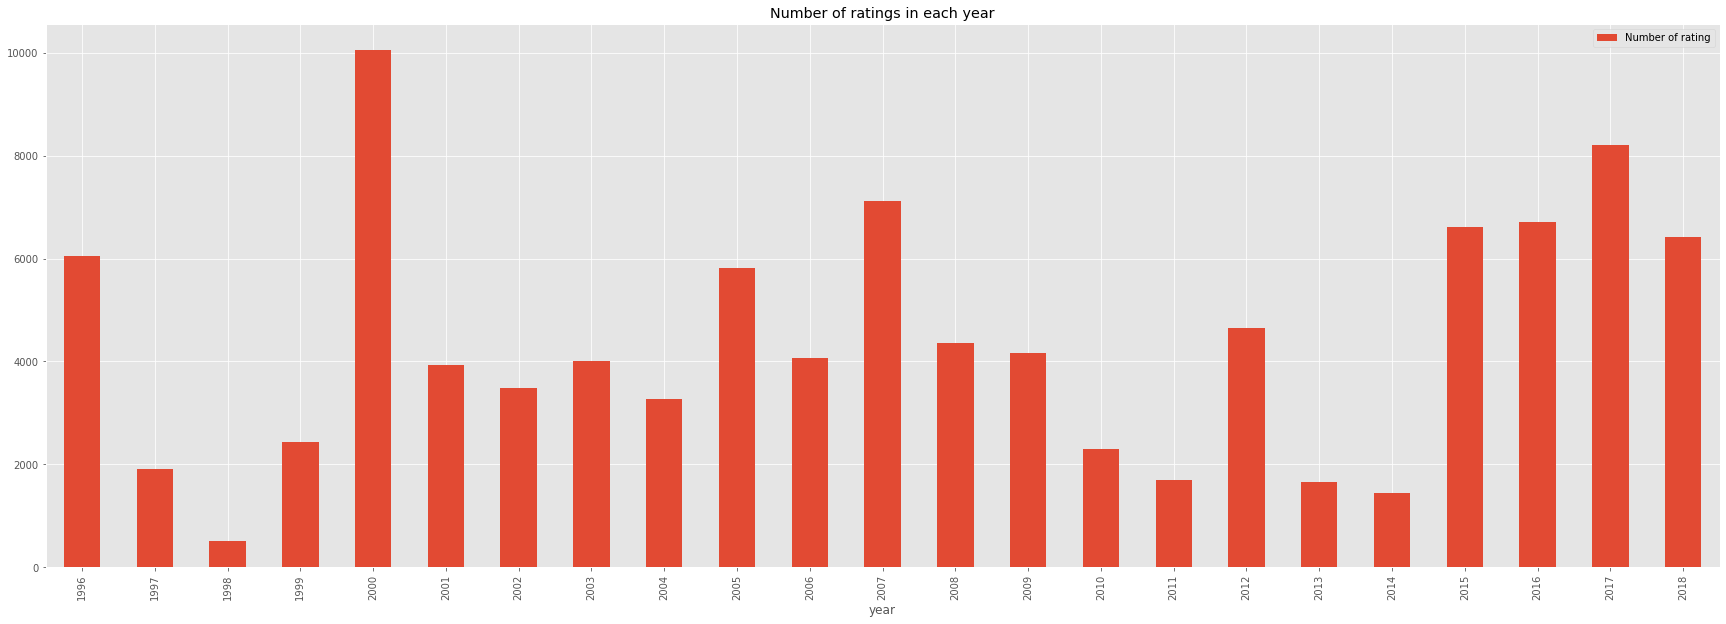

In [0]:
# แสดงกราฟค่า จำนวนการให้rating ในแต่ละปี
rate_movie = rating_df[['year', 'rating']].groupby(['year']).count()
rate_movie.columns = ['Number of rating']
rate_movie.plot.bar(figsize=(30,10), title='Number of ratings in each year')

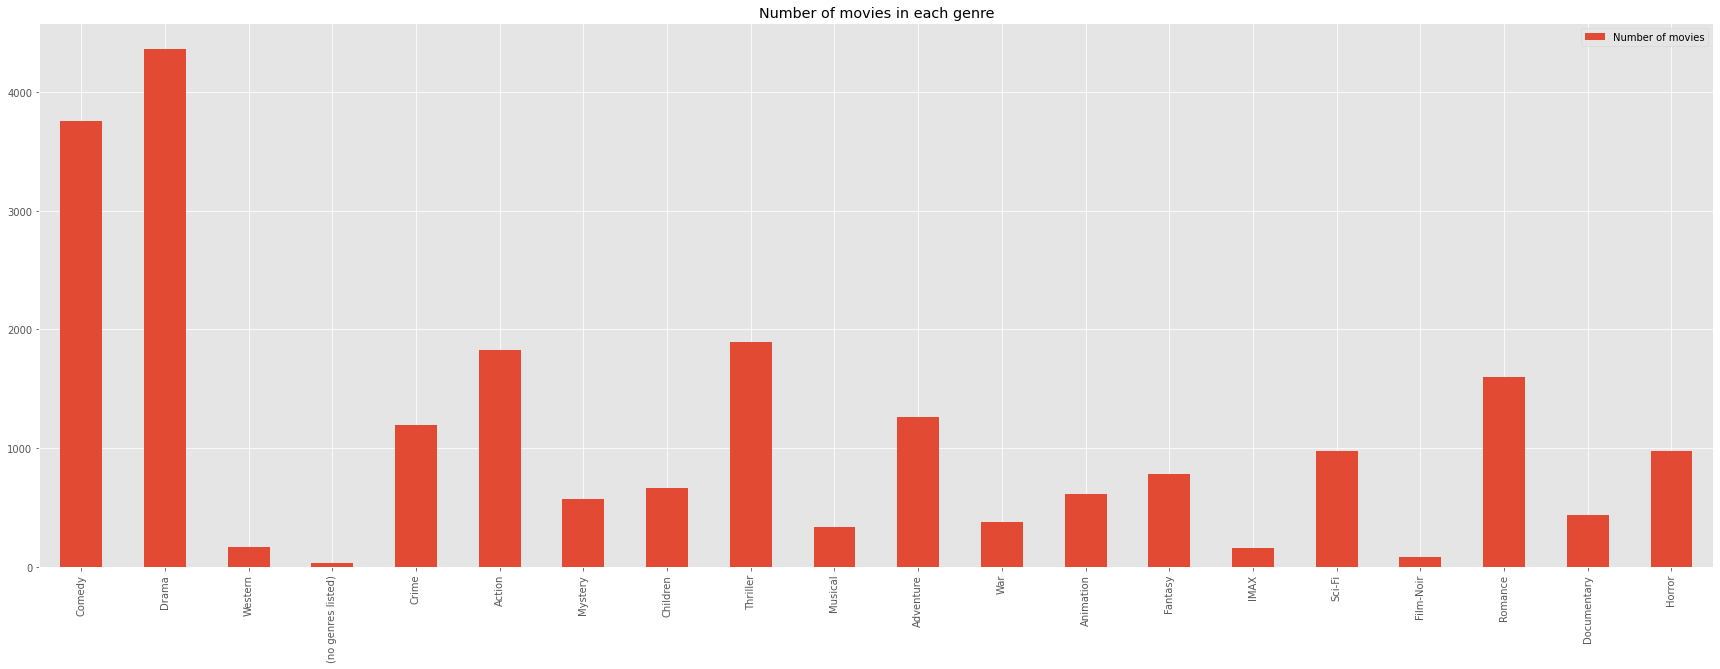

In [0]:
# แสดงกราฟค่า จำนวน movies ในแต่ละ genre
movie_genre = pd.DataFrame(genre_df.iloc[:, 1:].sum())
movie_genre.columns = ['Number of movies']
movie_genre.plot.bar(figsize=(30,10), title='Number of movies in each genre')

In [0]:
# # Create list of genre dataframe 
# temp_genre2 = movie_df.copy()
# temp_genre2['genres_split'] = temp_genre2['genres'].str.split(pat = "|")
# temp_genre2 = temp_genre2[['movieId', 'genres_split', 'year']]
# temp_genre2.columns = ['movieId', 'genres', 'year']
# temp_genre2

# # Create dataframe with 'movieId', 'genres', 'year'
# genre_mv_yr = pd.DataFrame(columns=['movieId', 'genres', 'year'])
# count_row = 0

# for index, row in temp_genre2.iterrows():
#   genre_set = list()
#   [genre_set.append(g) for g in row['genres']]
  
#   for i in genre_set:
#     genre_mv_yr.loc[count_row] = [row['movieId'], i, row['year']]
#     count_row += 1
# genre_mv_yr.to_csv(root_dir + '/genre_mv_yr.csv')
# genre_mv_yr

# =====================================================================

genre_mv_yr = pd.read_csv(root_dir + '/genre_mv_yr.csv')
genre_mv_yr.drop('Unnamed: 0', axis=1, inplace=True)
genre_mv_yr


,movieId,genres,year
0,1,Adventure,1995
1,1,Animation,1995
2,1,Children,1995
3,1,Comedy,1995
4,1,Fantasy,1995
...,...,...,...
22079,193583,Fantasy,2017
22080,193585,Drama,2017
22081,193587,Action,2018
22082,193587,Animation,2018


In [0]:
# แสดงกราฟ (y-axis: stacked graph) ค่าจำนวน movie แต่ละ genre ในแต่ละปี (x-axis)
genre_mv_yr_plot = genre_mv_yr.groupby(['genres', 'year']).count()
genre_mv_yr_plot

movieId
genres             year         
(no genres listed) 1957        1
                   1961        1
                   1968        1
                   1977        1
                   1980        1
...                          ...
Western            2013        1
                   2014        3
                   2015        4
                   2016        1
                   2017        2

[1503 rows x 1 columns]

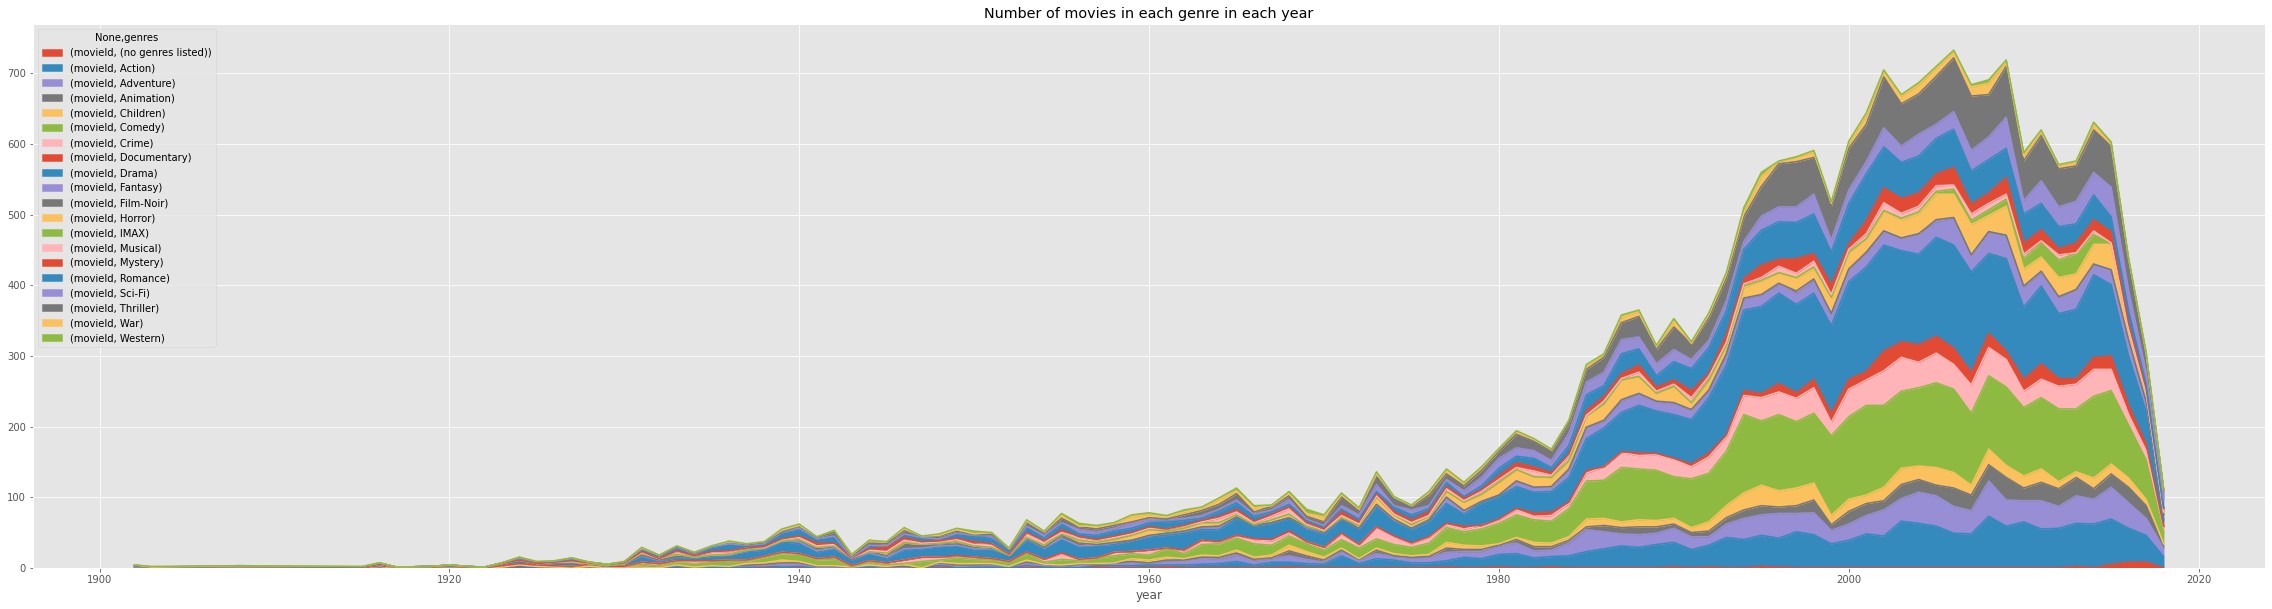

In [0]:
genre_mv_yr_plot.unstack(level=0).plot.area(stacked=True, figsize=(40,10), title='Number of movies in each genre in each year')

In [0]:
#  แสดงกราฟ Histogram ของการกระจายของค่าเฉลี่ย movie rating ใน dataset
sample_rating_df = rating_df[['userId', 'movieId', 'rating', ]].iloc[:100000]
sample_rating_df = sample_rating_df.sort_values(by=['userId', 'movieId'])
sample_rating_df

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
99995,610,6936,3.5
99996,610,6942,3.5
99997,610,6947,4.0
99998,610,6957,4.5


In [0]:
user_rate_mt = pd.DataFrame(index=sample_rating_df['userId'].unique(), columns=sample_rating_df['movieId'].sort_values().unique())      # Nan matrix

for index, row in sample_rating_df.iterrows():
    user_rate_mt.loc[row['userId'], row['movieId']] = row['rating']
  
user_rate_mt

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,185135,185435,185473,185585,186587,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,188833,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
1,4,NaN,4,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,4,NaN,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,2.5,NaN,NaN,NaN,3.5,NaN,4,4,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,4.5,NaN,NaN,4,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2,2,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,4.5,NaN,NaN,2,NaN,3.5,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,3,3.5,3.5,NaN,NaN,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
609,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
user_rate_mean = user_rate_mt.mean(axis=0)
user_rate_mean_df = pd.DataFrame(user_rate_mean)
user_rate_mean_df.columns = ['movie_rating_mean']
user_rate_mean_df.describe()

,movie_rating_mean
count,9569.000000
mean,3.254494
std,0.872639
min,0.500000
25%,2.760870
50%,3.400000
75%,3.900000
max,5.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd0e575fe48>]],
      dtype=object)

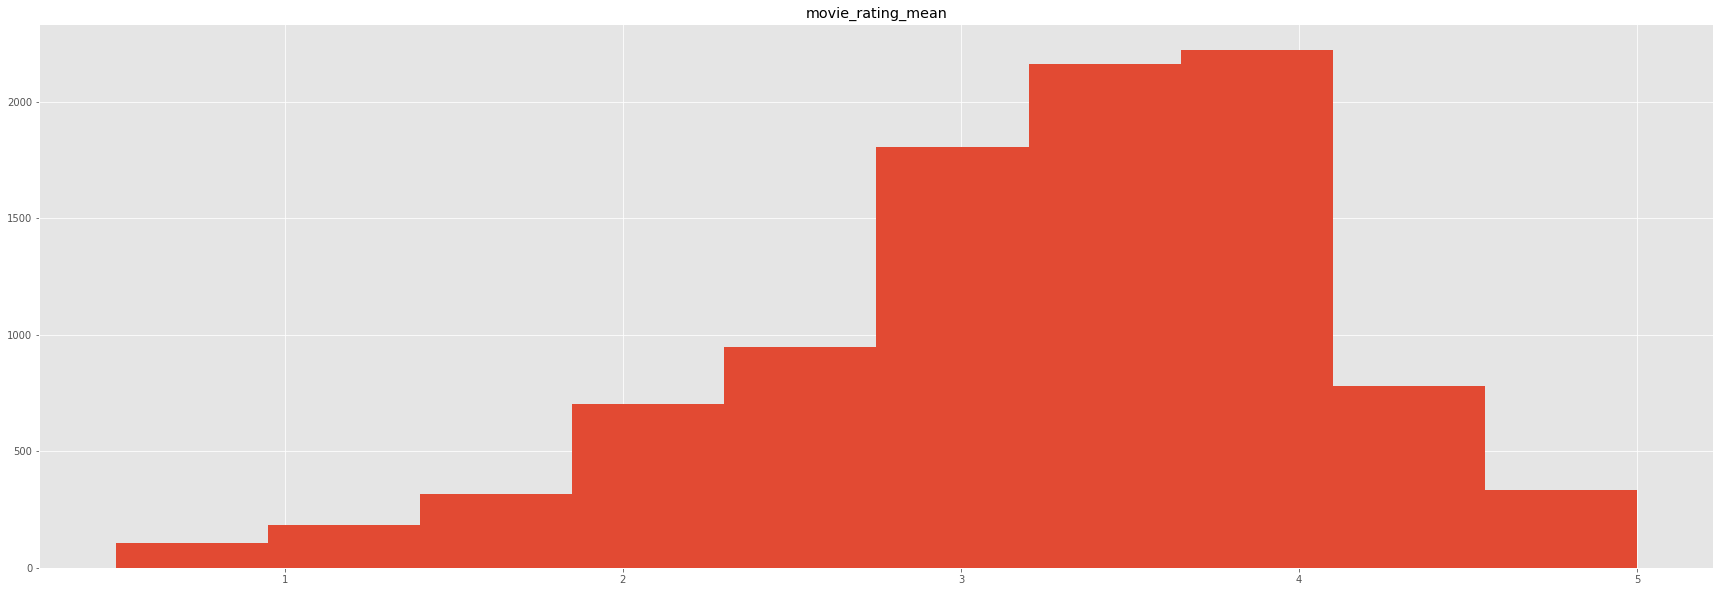

In [0]:
user_rate_mean_df.hist(bins=10, figsize=(30,10))

# ตอนที่ 2: การทดลองสร้างระบบแนะนำสินค้า (Recommendation system) จากข้อมูล user_matrix

### สร้างข้อมูลความชอบของผู้ใช้แต่ละคน (user_ matrix)

In [0]:
sample_rating_df = rating_df[['userId', 'movieId', 'rating', ]]
sample_rating_df = sample_rating_df

# Create nan matrix 
user_rate_mt = pd.DataFrame(index=sample_rating_df['userId'].unique(), columns=sample_rating_df['movieId'].unique())      # Nan matrix

for index, row in sample_rating_df.iterrows():
    user_rate_mt.loc[row['userId'], row['movieId']] = row['rating']
user_rate_mt.fillna(0, inplace=True)
user_rate_mt.columns.name = 'movieid'
user_rate_mt.index.name = 'userid'
user_rate_mt

movieid,1,3,6,47,50,70,101,110,151,157,163,216,223,231,235,260,296,316,333,349,356,362,367,423,441,457,480,500,527,543,552,553,590,592,593,596,608,648,661,673,...,113565,113780,113862,114044,114670,114707,115727,117867,118082,128838,129313,130050,130052,130840,133832,135534,135803,135815,138610,138632,139511,139655,140267,141400,141799,142366,142598,145951,146309,147657,147662,148166,149011,152372,158721,160341,160527,160836,163937,163981
userid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,4.0,4.0,5.0,5.0,3.0,5.0,4.0,5.0,5.0,5.0,5.0,3.0,5.0,4.0,5.0,3.0,3.0,5.0,4.0,4.0,5.0,4.0,3.0,4.0,5.0,4.0,3.0,5.0,4.0,4.0,5.0,4.0,4.0,4.0,5.0,5.0,3.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,5.0,0.0,5.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,3.0,0.0,5.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,3.0,4.5,4.0,0.0,3.5,0.0,4.0,0.0,0.0,4.5,2.5,3.5,4.5,5.0,0.0,0.0,0.0,4.0,2.5,3.0,0.0,0.0,0.0,2.5,3.0,5.0,0.0,3.0,0.0,4.0,3.5,4.5,3.0,0.0,2.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,4.0,0.0,5.0,0.0,0.0,4.0,0.0,3.0,5.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,0.0,4.5,4.5,3.0,0.0,4.0,0.0,0.0,3.0,2.5,2.5,3.0,0.0,3.5,5.0,3.0,4.0,0.0,3.0,0.0,2.0,3.0,4.5,3.0,3.0,2.0,4.0,3.5,1.5,3.5,3.0,3.0,4.0,0.5,3.0,3.5,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##  คำนวณความคล้ายกันของความชอบดูหนังของคู่ ‘userId’ ใดๆ

In [0]:
# Random 30 user
random_mt = user_rate_mt.sample(30)

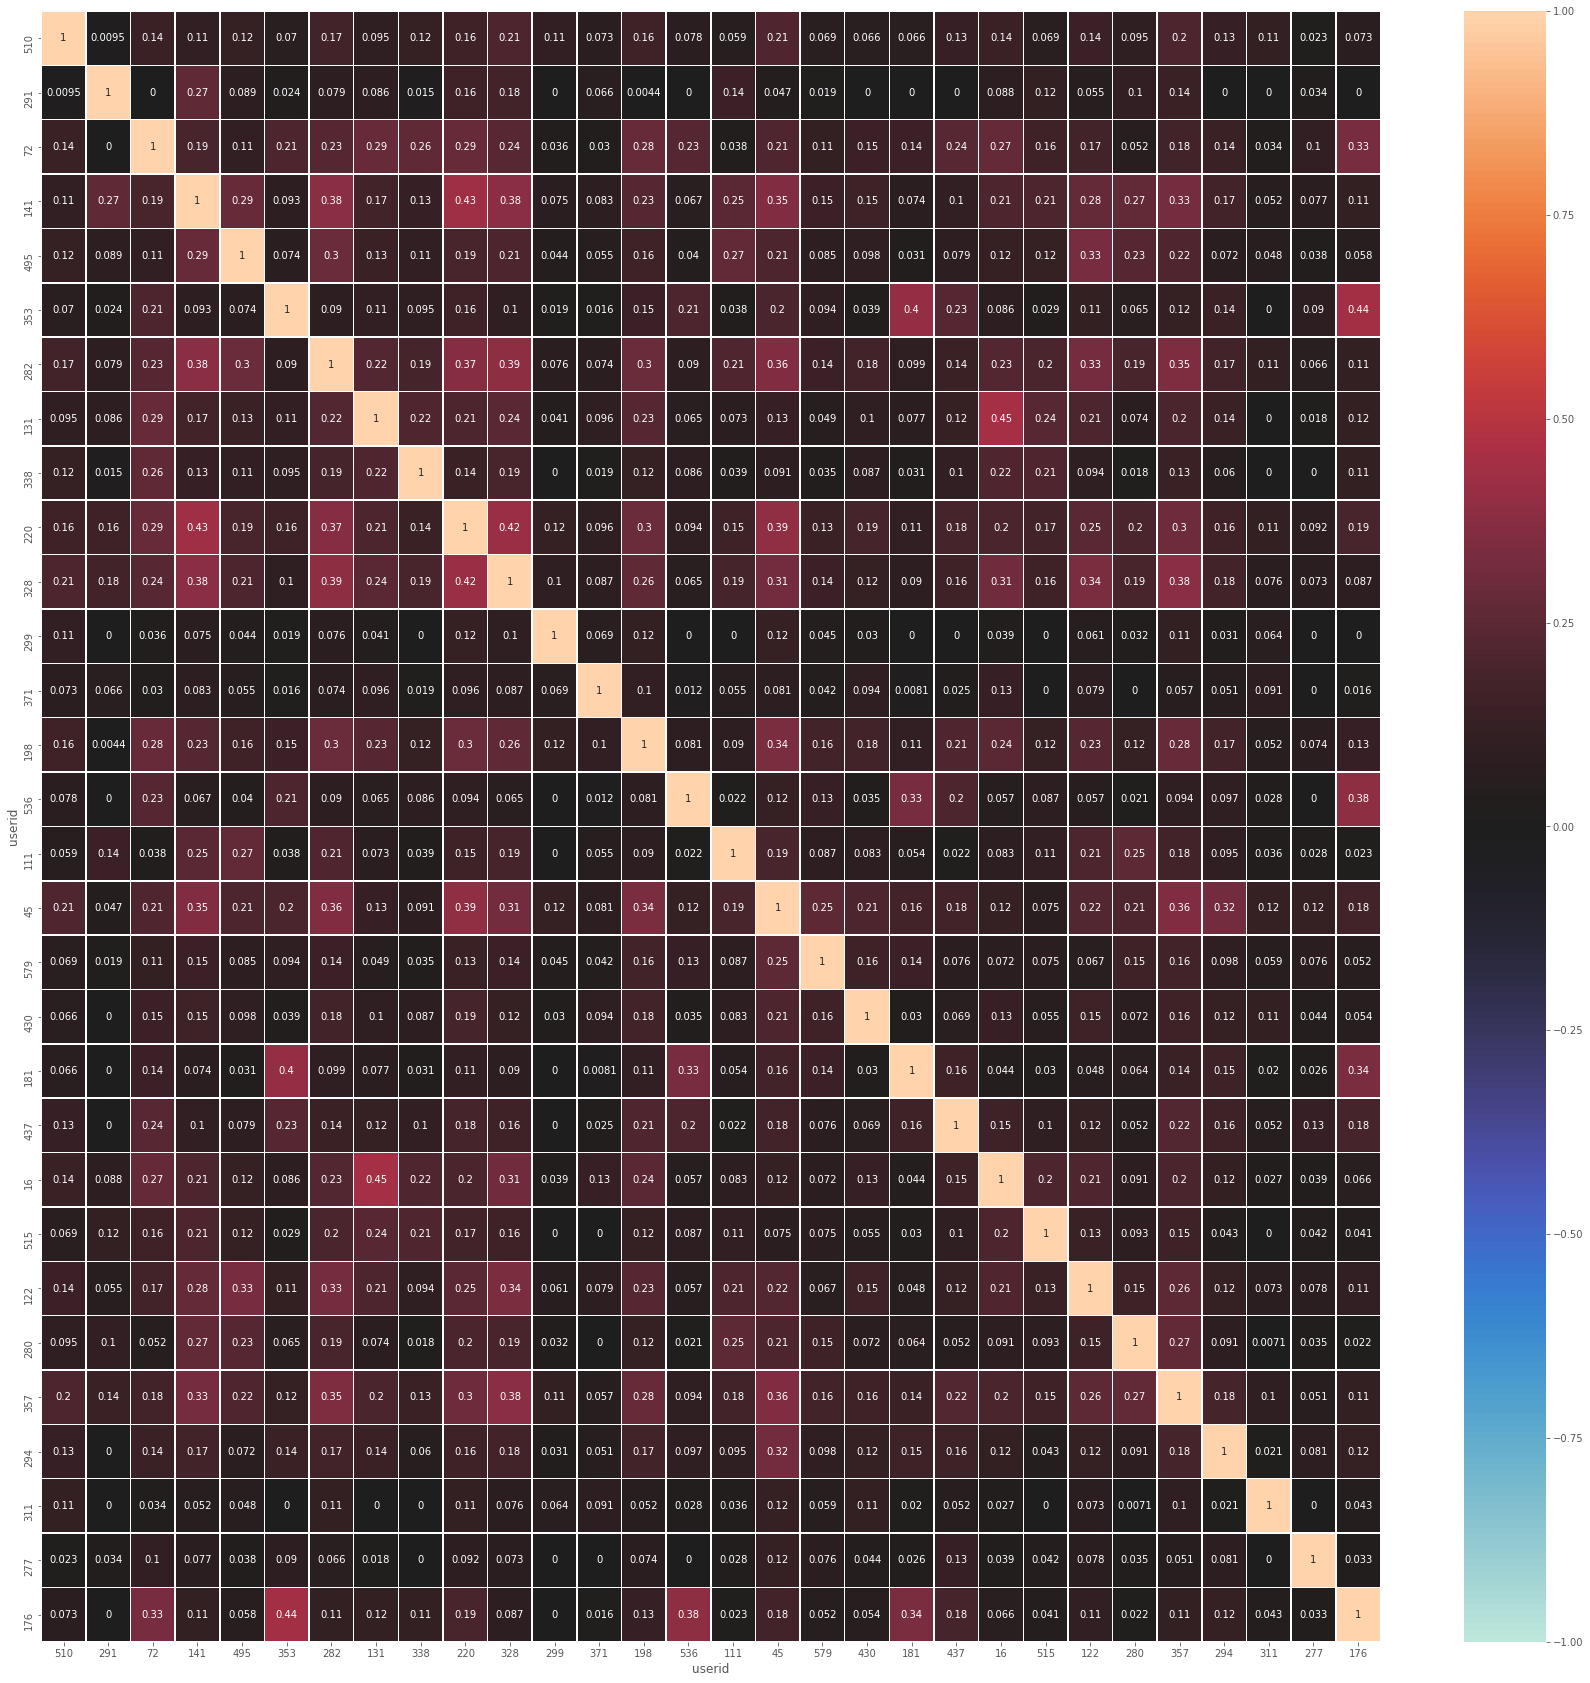

In [0]:
# cosine_similarity
cos_sim = cosine_similarity(random_mt, random_mt)
cos_sim = pd.DataFrame(cos_sim)
cos_sim.columns.name = 'userid'
cos_sim.index.name = 'userid'

fig, ax = plt.subplots(figsize=(30,30))  
sns.heatmap(cos_sim, annot = True, vmin=-1, vmax=1, center= 0, linewidths=.5, ax=ax, xticklabels=random_mt.index, yticklabels=random_mt.index)

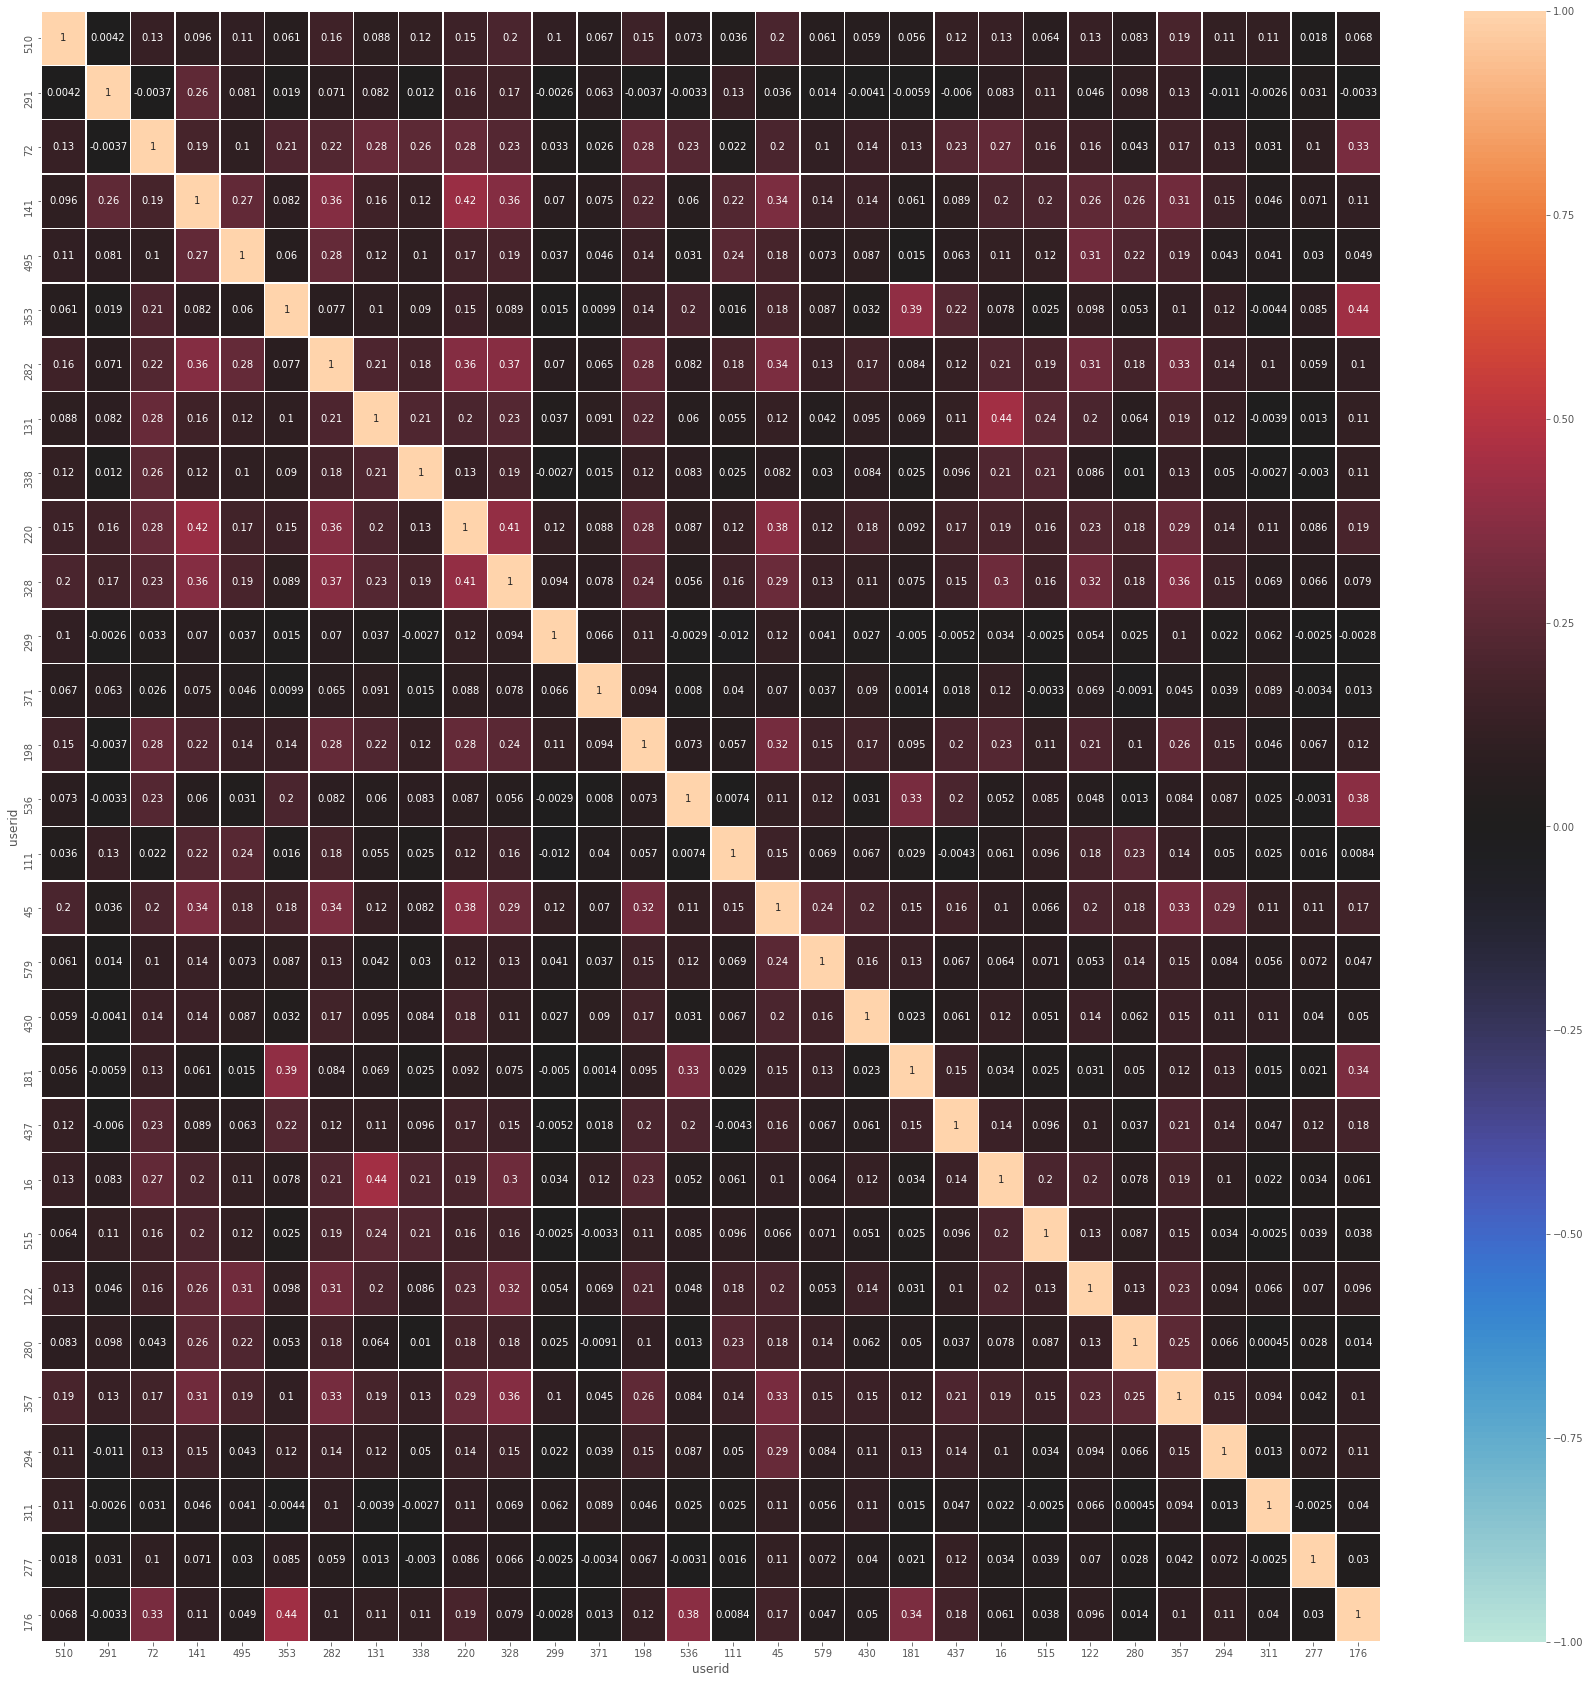

In [0]:
#  Pearson’s similarity()
pearson_sim = random_mt.T.corr( method ='pearson' )
fig, ax = plt.subplots(figsize=(30,30))  
sns.heatmap(pearson_sim, annot = True, vmin=-1, vmax=1, center= 0, linewidths=.5, ax=ax, xticklabels=random_mt.index, yticklabels=random_mt.index)

### แสดงตารางรายการดังนี้


In [0]:
def display_top_sim(corr_df, method) :
  corr_df = corr_df
  sort_corr = (corr_df.where(np.triu(np.ones(corr_df.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))            #the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
  print(f"\n*************************** {method} *************************** ")
  print("------ Top 5 Similarity ------")
  print(sort_corr[0: 5])
  # print('\n---------------------------------------------------------------------\n')
  print("------ Top 5 Diffence ------")
  print(sort_corr[-5: ])

  return sort_corr[0: 5], sort_corr[-5: ]

In [0]:
# ตาราง user ที่มีความชอบตรงกันข้ามกันที่สุด 5 อันดับ cosine_similarity
cos_like, cos_dislike = display_top_sim(cos_sim, 'Cosine similarity')

# ตาราง user ที่มีความชอบตรงกันข้ามกันที่สุด 5 อันดับ Pearson’s similarity
pear_like, pear_dislike = display_top_sim(pearson_sim, 'Pearson’s similarity')


*************************** Cosine similarity *************************** 
------ Top 5 Similarity ------
userid  userid
7       21        0.446127
5       29        0.438942
3       9         0.431281
9       10        0.417976
5       19        0.399197
dtype: float64
------ Top 5 Diffence ------
userid  userid
11      15        0.0
        29        0.0
        28        0.0
        19        0.0
        22        0.0
dtype: float64

*************************** Pearson’s similarity *************************** 
------ Top 5 Similarity ------
userid  userid
131     16        0.441613
353     176       0.436084
141     220       0.420804
220     328       0.405333
353     181       0.393371
dtype: float64
------ Top 5 Diffence ------
userid  userid
291     181      -0.005853
        437      -0.006039
371     280      -0.009103
291     294      -0.010911
299     111      -0.012071
dtype: float64


In [0]:
# รายการของคนที่มีความชอบคล้ายกันที่สุด และรายการคนที่มีความชอบตรงข้ามกันที่สุด

In [0]:
cos_like_df = pd.DataFrame(cos_like)
cos_like_df.columns = ['similarity']
cos_like_df['method'] = 'cosine_sim'

cos_dislike_df = pd.DataFrame(cos_dislike)
cos_dislike_df.columns = ['similarity']
cos_dislike_df['method'] = 'cosine_sim'


pear_like_df = pd.DataFrame(pear_like)
pear_like_df.columns = ['similarity']
pear_like_df['method'] = 'pearson_sim'

pear_dislike_df = pd.DataFrame(pear_dislike)
pear_dislike_df.columns = ['similarity']
pear_dislike_df['method'] = 'pearson_sim'

In [0]:
sim_df = pd.concat([cos_like_df, pear_like_df])
sim_df = (sim_df.sort_values('similarity', ascending=False))

sim_df

,,similarity,method
userid,userid,,
7,21,0.446127,cosine_sim
131,16,0.441613,pearson_sim
5,29,0.438942,cosine_sim
353,176,0.436084,pearson_sim
3,9,0.431281,cosine_sim
141,220,0.420804,pearson_sim
9,10,0.417976,cosine_sim
220,328,0.405333,pearson_sim
5,19,0.399197,cosine_sim


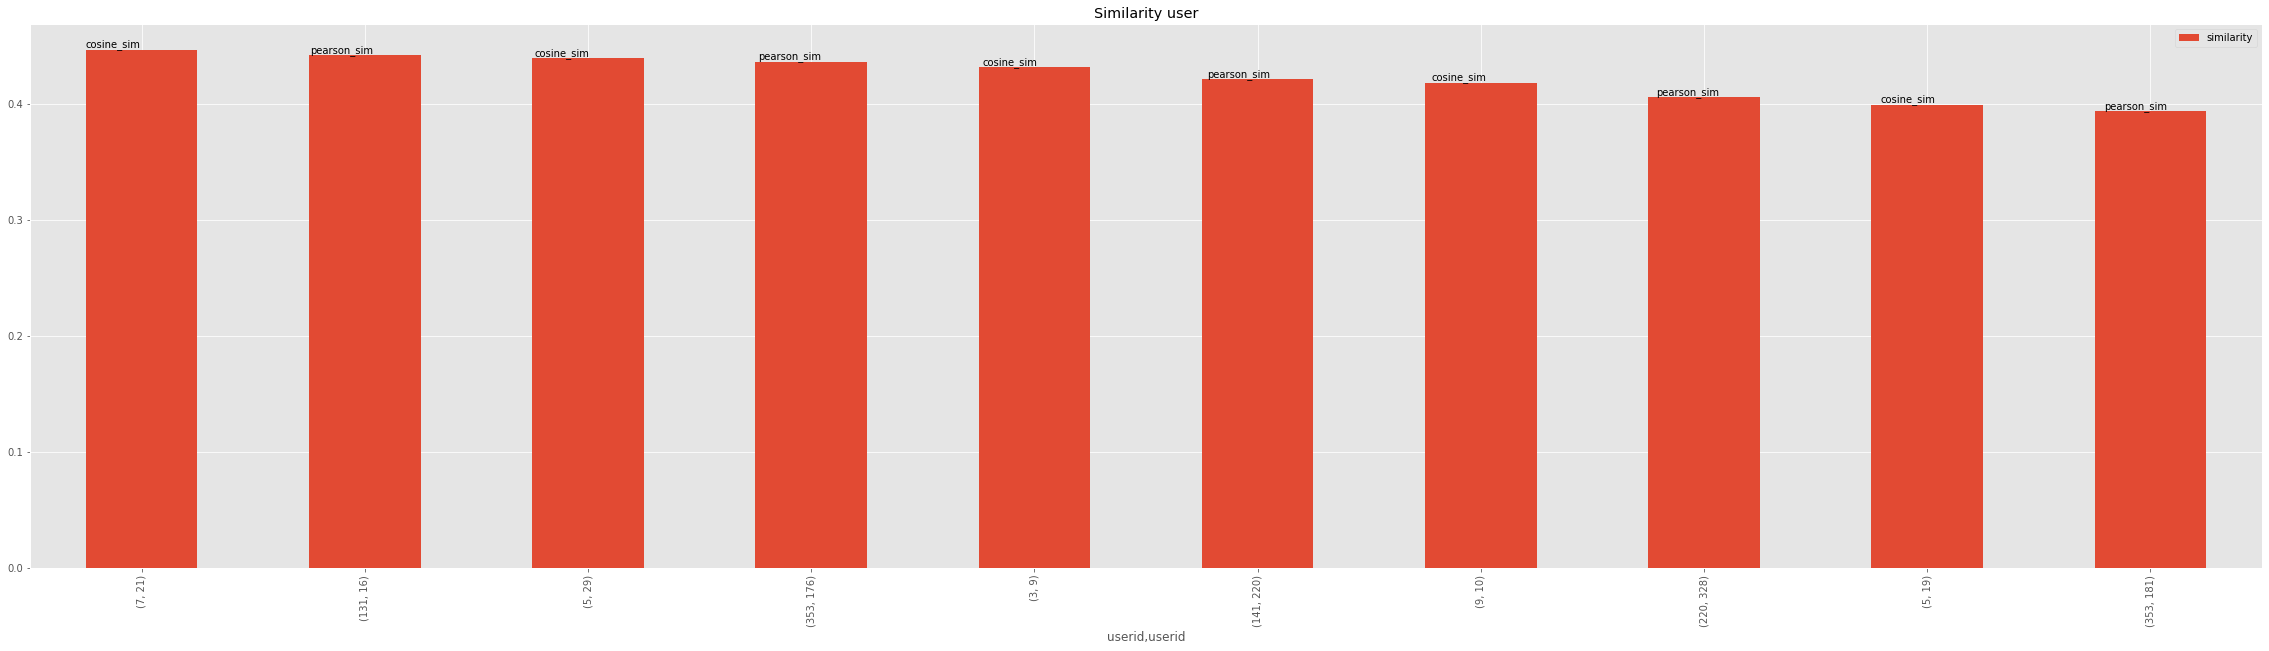

In [0]:
ax = sim_df.plot(kind='bar', figsize=(40,10), title='Similarity user')
i = 0
for p in ax.patches:
  ax.annotate(sim_df.iloc[i, -1], (p.get_x() * 1.005, p.get_height() * 1.005))
  i+=1

In [0]:
diff_df = pd.concat([cos_dislike_df, pear_dislike_df])
diff_df = (diff_df.sort_values('similarity'))

diff_df

similarity       method
userid userid                         
299    111      -0.012071  pearson_sim
291    294      -0.010911  pearson_sim
371    280      -0.009103  pearson_sim
291    437      -0.006039  pearson_sim
       181      -0.005853  pearson_sim
11     15        0.000000   cosine_sim
       29        0.000000   cosine_sim
       28        0.000000   cosine_sim
       19        0.000000   cosine_sim
       22        0.000000   cosine_sim

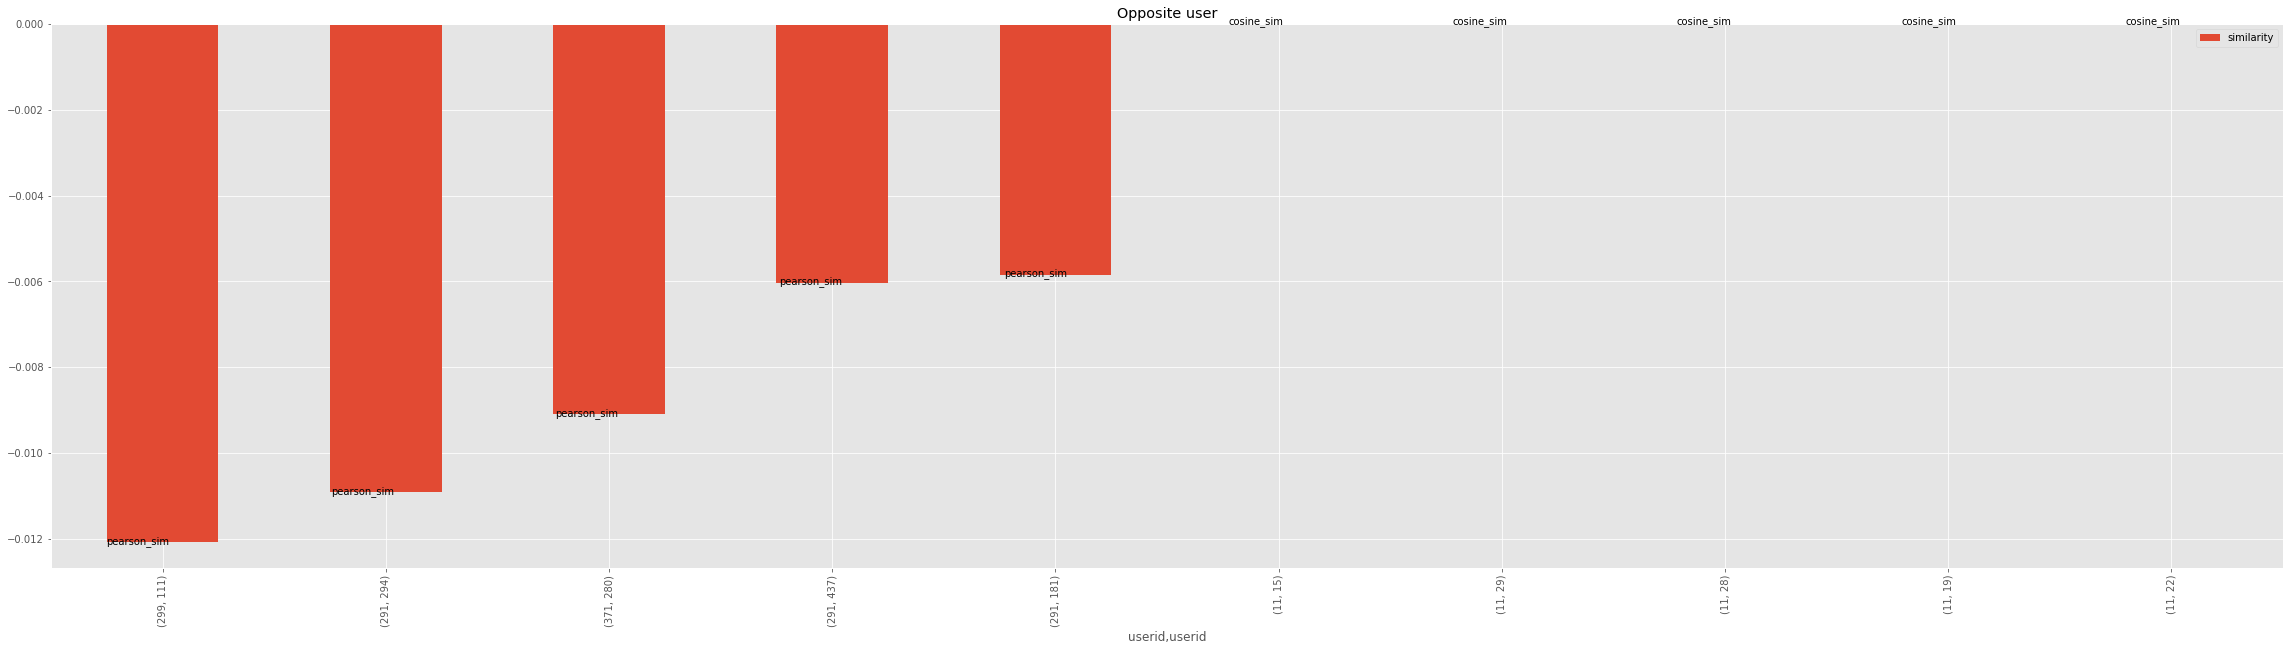

In [0]:
ax = diff_df.plot(kind='bar', figsize=(40,10), title='Opposite user')
i = 0
for p in ax.patches:
  ax.annotate(diff_df.iloc[i, -1], (p.get_x() * 1.005, p.get_height() * 1.005))
  i+=1

## แสดงรูปภาพ

In [0]:
corr_df = pearson_sim
pear_like = (corr_df.where(np.triu(np.ones(corr_df.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))

pear_df = pd.DataFrame(pear_like)
pear_df.columns = ['similarity']
pear_df.index.names = ['user_1', 'user_2']
pear_df.reset_index(inplace=True)

# set of users
users = set(pear_df['user_1'].unique())
user_2 = set(pear_df['user_2'].unique())
users.update(user_2)
users = list(users)

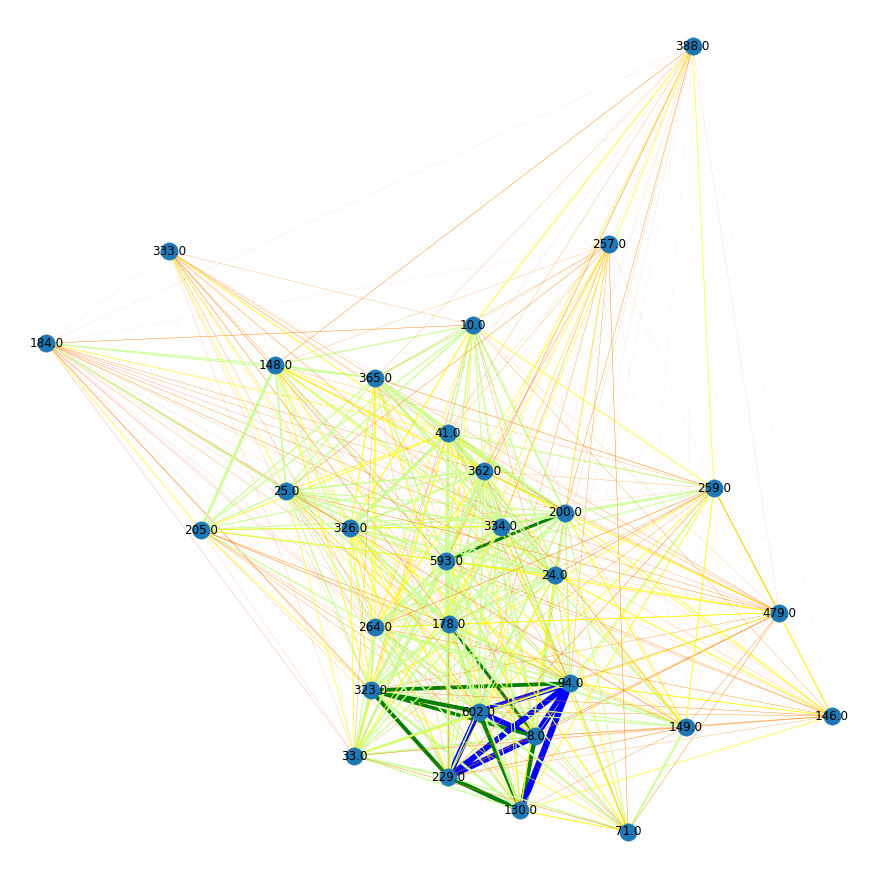

In [0]:
from networkx import nx
from matplotlib.lines import Line2D

# Create New Graph
G = nx.Graph()

# tt = pear_df.iloc[0]
# G.add_edge(tt['user_1'], tt['user_2'], weight=tt['similarity'], color="blue")


for index, row in pear_df.iterrows():

# Similar user
  if row['similarity'] >= 0.5 :
    G.add_edge(row['user_1'], row['user_2'], weight=row['similarity'], color='b')            # blue

  elif row['similarity'] >= 0.3 :
    G.add_edge(row['user_1'], row['user_2'], weight=row['similarity'], color='g')            # green

  elif row['similarity'] >= 0.1 :
    G.add_edge(row['user_1'], row['user_2'], weight=row['similarity'], color='#CCFF99')      # lightgreen

# Opposite user
  elif row['similarity'] >= 0.05 :
    G.add_edge(row['user_1'], row['user_2'], weight=row['similarity'], color='#FFFF00')       # yellow

  elif row['similarity'] >= 0.00 :
    G.add_edge(row['user_1'], row['user_2'], weight=row['similarity'], color='#FF8000')       # orange

  elif row['similarity'] < 0 : 
    G.add_edge(row['user_1'], row['user_2'], weight=row['similarity'], color='r')             # red

G.size(100)
pos = nx.spring_layout(G)
edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight']*10 for u,v in edges]

plt.figure(3,figsize=(12,12)) 
nx.draw(G, pos, edges=edges, edge_color=colors, width=weights)
nx.draw_networkx_labels(G, pos)
plt.show()

In [0]:
#  แสดงรูปตาราง movie title ที่ rating สูงสุด ที่ควรแนะนำของคนที่มีความชอบคล้ายกันที่สุด ที่ควรแนะนำให้ดู
pearson_sim = random_mt.T.corr( method ='pearson' )
np.fill_diagonal(pearson_sim.values, np.nan)

# Find similar user
user_sim_df = pd.DataFrame(pearson_sim.stack())
user_sim_df.columns = ['similarity']
user_sim_df.index.names = ['user_1', 'user_2']
user_sim_df = user_sim_df.groupby(level=0).idxmax()

# Create NaN table
user_mv_rate_df = pd.DataFrame(index=user_sim_df.index, columns=['sim_userId', 'movie_title', 'movie_rating'])
user_mv_rate_df.index.name = 'userId'

# Fill similar user
for idx, row in user_sim_df.iterrows():
  user_mv_rate_df.loc[idx, 'sim_userId'] = row['similarity'][1]

# Find max user rate movie
mov_rate_df = pd.DataFrame(user_rate_mt.loc[user_mv_rate_df['sim_userId'].values].idxmax(axis=1), columns=['movie_id'])

# Find movie title
temp_movie = movie_df.copy()
temp_movie.set_index('movieId', inplace=True)
temp_movie = pd.DataFrame(temp_movie.loc[mov_rate_df['movie_id'].values, 'title'])
temp_movie.reset_index(inplace=True)
temp_movie.set_index(mov_rate_df.index, inplace=True)
mov_rate_df['movie_title'] = temp_movie['title']
mov_rate_df['movie_rating'] = np.nan

# find movie rating
sim_user_rate_mt = user_rate_mt.loc[mov_rate_df.index]
sim_user_rate_mt.drop_duplicates(inplace=True) 

temp_mov_rate_df = mov_rate_df.copy()
temp_mov_rate_df.reset_index(inplace=True)
for idx, row in temp_mov_rate_df.iterrows():
  temp_mov_rate_df.loc[idx ,'movie_rating'] = sim_user_rate_mt.loc[row['userid'], row['movie_id']]
mov_rate_df = temp_mov_rate_df.copy()

# Fill title and rating
user_mv_rate_df['movie_title'] = mov_rate_df['movie_title'].values
user_mv_rate_df['movie_rating'] = mov_rate_df['movie_rating'].values

user_mv_rate_df

,sim_userId,movie_title,movie_rating
userId,,,
8,94,Braveheart (1995),5.0
10,200,Star Wars: Episode IV - A New Hope (1977),5.0
24,200,Star Wars: Episode IV - A New Hope (1977),5.0
25,334,Shrek (2001),4.5
33,323,"Shawshank Redemption, The (1994)",5.0
41,326,Braveheart (1995),5.0
71,149,Alien (1979),5.0
94,8,"Usual Suspects, The (1995)",5.0
130,94,Braveheart (1995),5.0


In [0]:
# แสดงรูปตาราง movie title ที่ rating สูงสุด ของคนที่มีความชอบตรงข้ามกันที่สุด ที่ไม่ควรแนะนำให้ดู
pearson_sim = random_mt.T.corr( method ='pearson' )
np.fill_diagonal(pearson_sim.values, np.nan)

# Find opposite user
user_sim_df = pd.DataFrame(pearson_sim.stack())
user_sim_df.columns = ['opposity']
user_sim_df.index.names = ['user_1', 'user_2']
user_sim_df = user_sim_df.groupby(level=0).idxmin()

# Create NaN table
user_mv_rate_df = pd.DataFrame(index=user_sim_df.index, columns=['opp_userId', 'movie_title', 'movie_rating'])
user_mv_rate_df.index.name = 'userId'

# Fill opposite user
for idx, row in user_sim_df.iterrows():
  user_mv_rate_df.loc[idx, 'opp_userId'] = row['opposity'][1]

# Find max user rate movie
mov_rate_df = pd.DataFrame(user_rate_mt.loc[user_mv_rate_df['opp_userId'].values].idxmax(axis=1), columns=['movie_id'])

# Find movie title
temp_movie = movie_df.copy()
temp_movie.set_index('movieId', inplace=True)
temp_movie = pd.DataFrame(temp_movie.loc[mov_rate_df['movie_id'].values, 'title'])
temp_movie.reset_index(inplace=True)
temp_movie.set_index(mov_rate_df.index, inplace=True)
mov_rate_df['movie_title'] = temp_movie['title']
mov_rate_df['movie_rating'] = np.nan

# find movie rating
sim_user_rate_mt = user_rate_mt.loc[mov_rate_df.index]
sim_user_rate_mt.drop_duplicates(inplace=True) 

temp_mov_rate_df = mov_rate_df.copy()
temp_mov_rate_df.reset_index(inplace=True)
for idx, row in temp_mov_rate_df.iterrows():
  temp_mov_rate_df.loc[idx ,'movie_rating'] = sim_user_rate_mt.loc[row['userid'], row['movie_id']]
mov_rate_df = temp_mov_rate_df.copy()

# Fill title and rating
user_mv_rate_df['movie_title'] = mov_rate_df['movie_title'].values
user_mv_rate_df['movie_rating'] = mov_rate_df['movie_rating'].values

user_mv_rate_df

,opp_userId,movie_title,movie_rating
userId,,,
8,184,"Dark Knight, The (2008)",5.0
10,149,Alien (1979),5.0
24,388,Shrek (2001),5.0
25,146,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),5.0
33,184,"Dark Knight, The (2008)",5.0
41,71,Toy Story (1995),5.0
71,10,"Dark Knight Rises, The (2012)",5.0
94,184,"Dark Knight, The (2008)",5.0
130,184,"Dark Knight, The (2008)",5.0


# ตอนที่ 3: การทดลองสร้างระบบแนะนำสินค้า (Recommendation system) จากข้อมูล movie_matrix

### คำนวณความคล้ายกันของ movie genre ของคู่ ‘movieId’ ใดๆ จากตาราง movie genre feature 

In [0]:
# Random 30 movie
random_genre_df =  genre_df.sample(30)
random_genre_df.reset_index(inplace=True, drop=True)
random_genre_df.set_index('movieId', inplace=True)
random_genre_df.head()

,Romance,Mystery,Western,Children,Adventure,Thriller,Musical,Sci-Fi,Drama,Comedy,Fantasy,Documentary,Animation,Horror,IMAX,Crime,Action,Film-Noir,(no genres listed),War
movieId,,,,,,,,,,,,,,,,,,,,
1325,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2412,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
48385,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3096,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3730,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


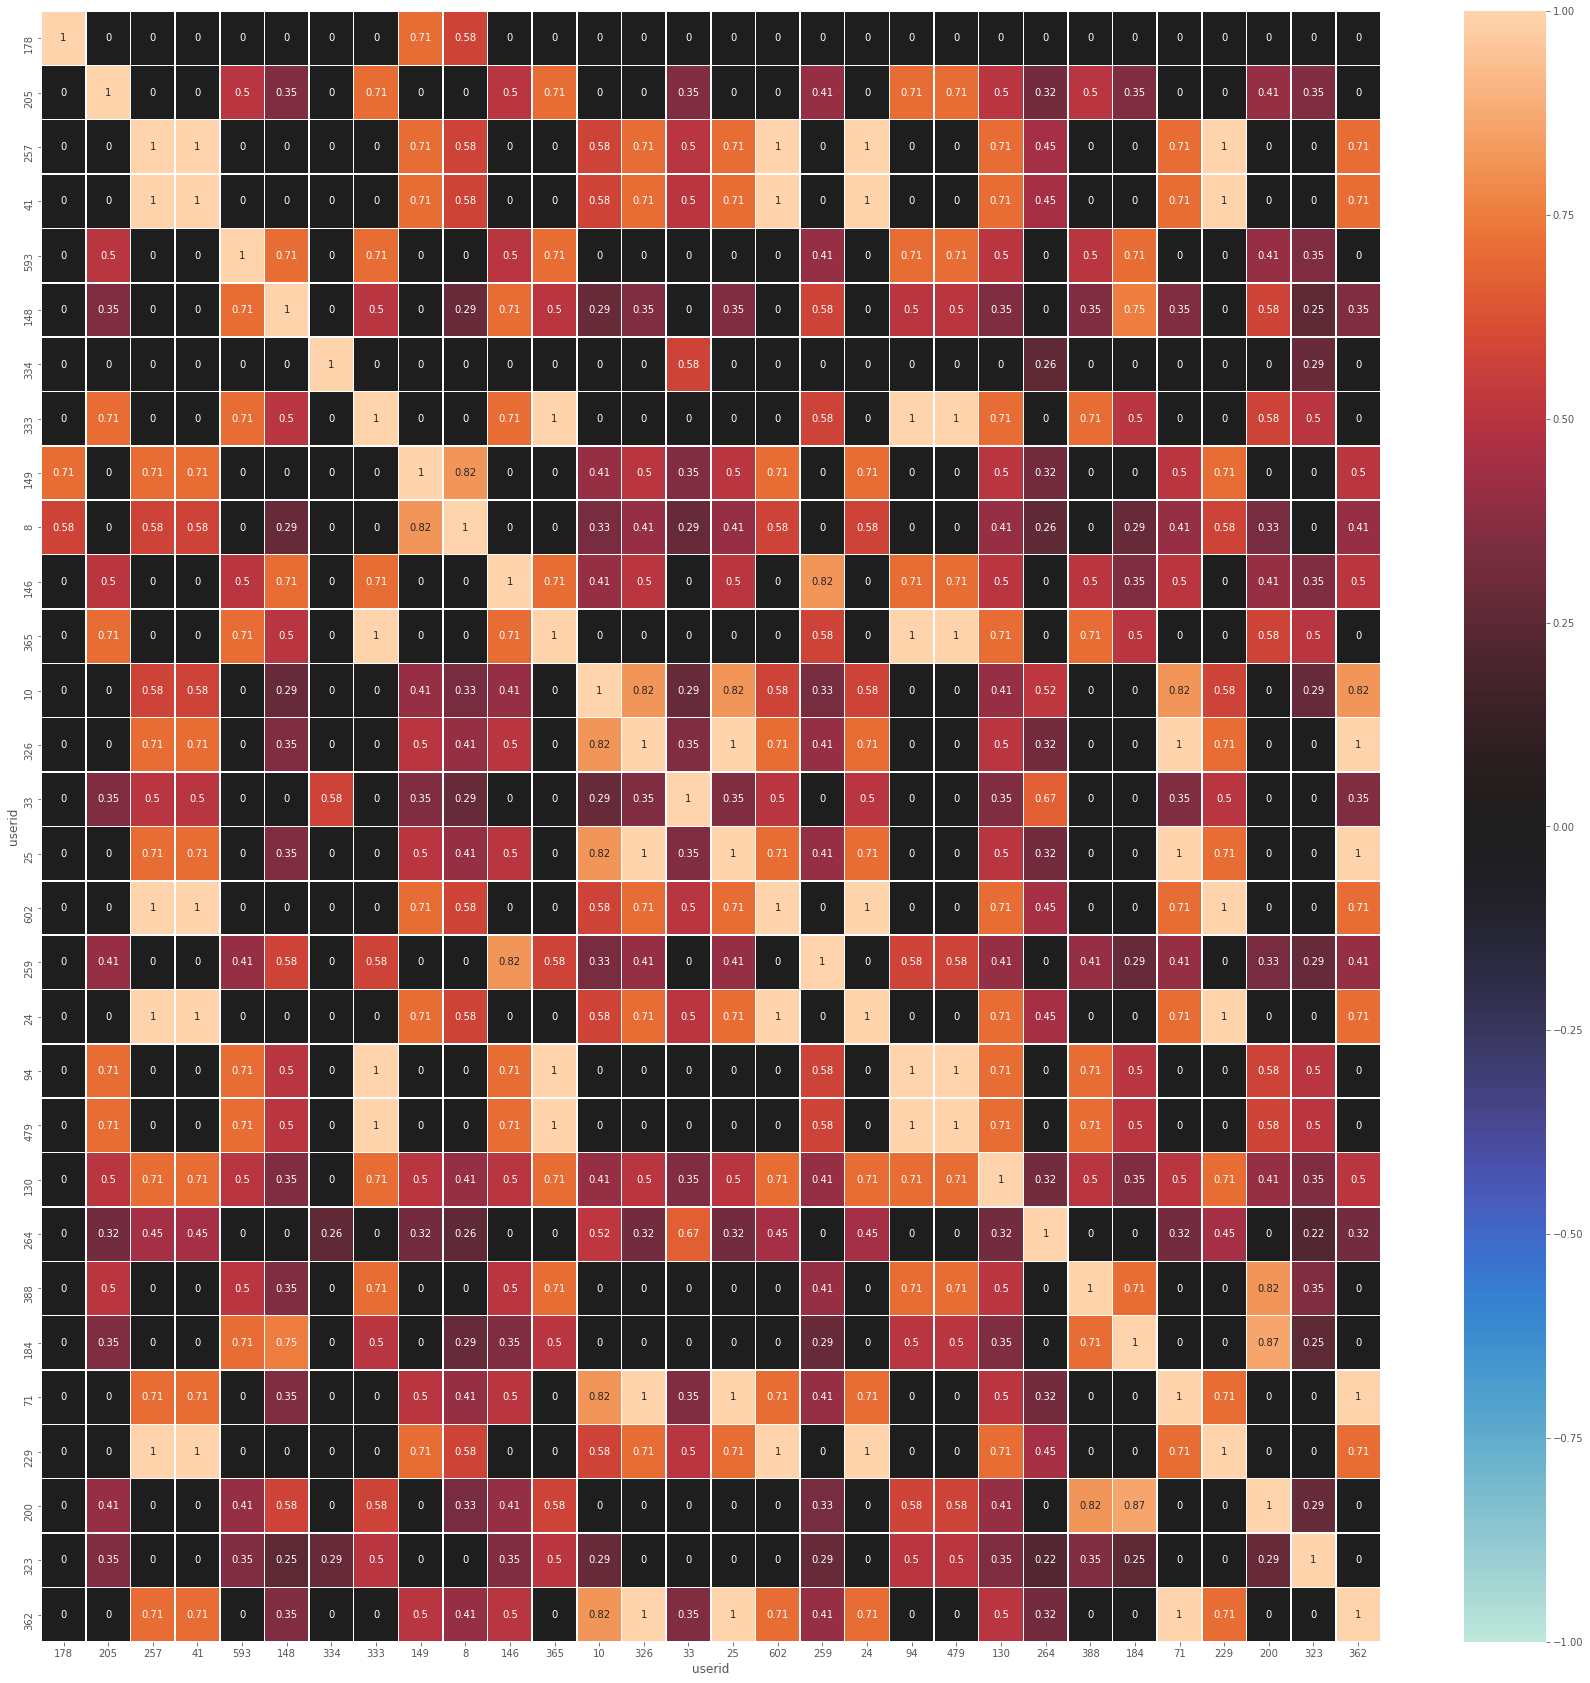

In [0]:
# cosine_similarity
cos_genre_sim = cosine_similarity(random_genre_df, random_genre_df)
cos_genre_sim = pd.DataFrame(cos_genre_sim)
cos_genre_sim.columns.name = 'userid'
cos_genre_sim.index.name = 'userid'

fig, ax = plt.subplots(figsize=(30,30))  
sns.heatmap(cos_genre_sim, annot = True, vmin=-1, vmax=1, center= 0, linewidths=.5, ax=ax, xticklabels=random_mt.index, yticklabels=random_mt.index)

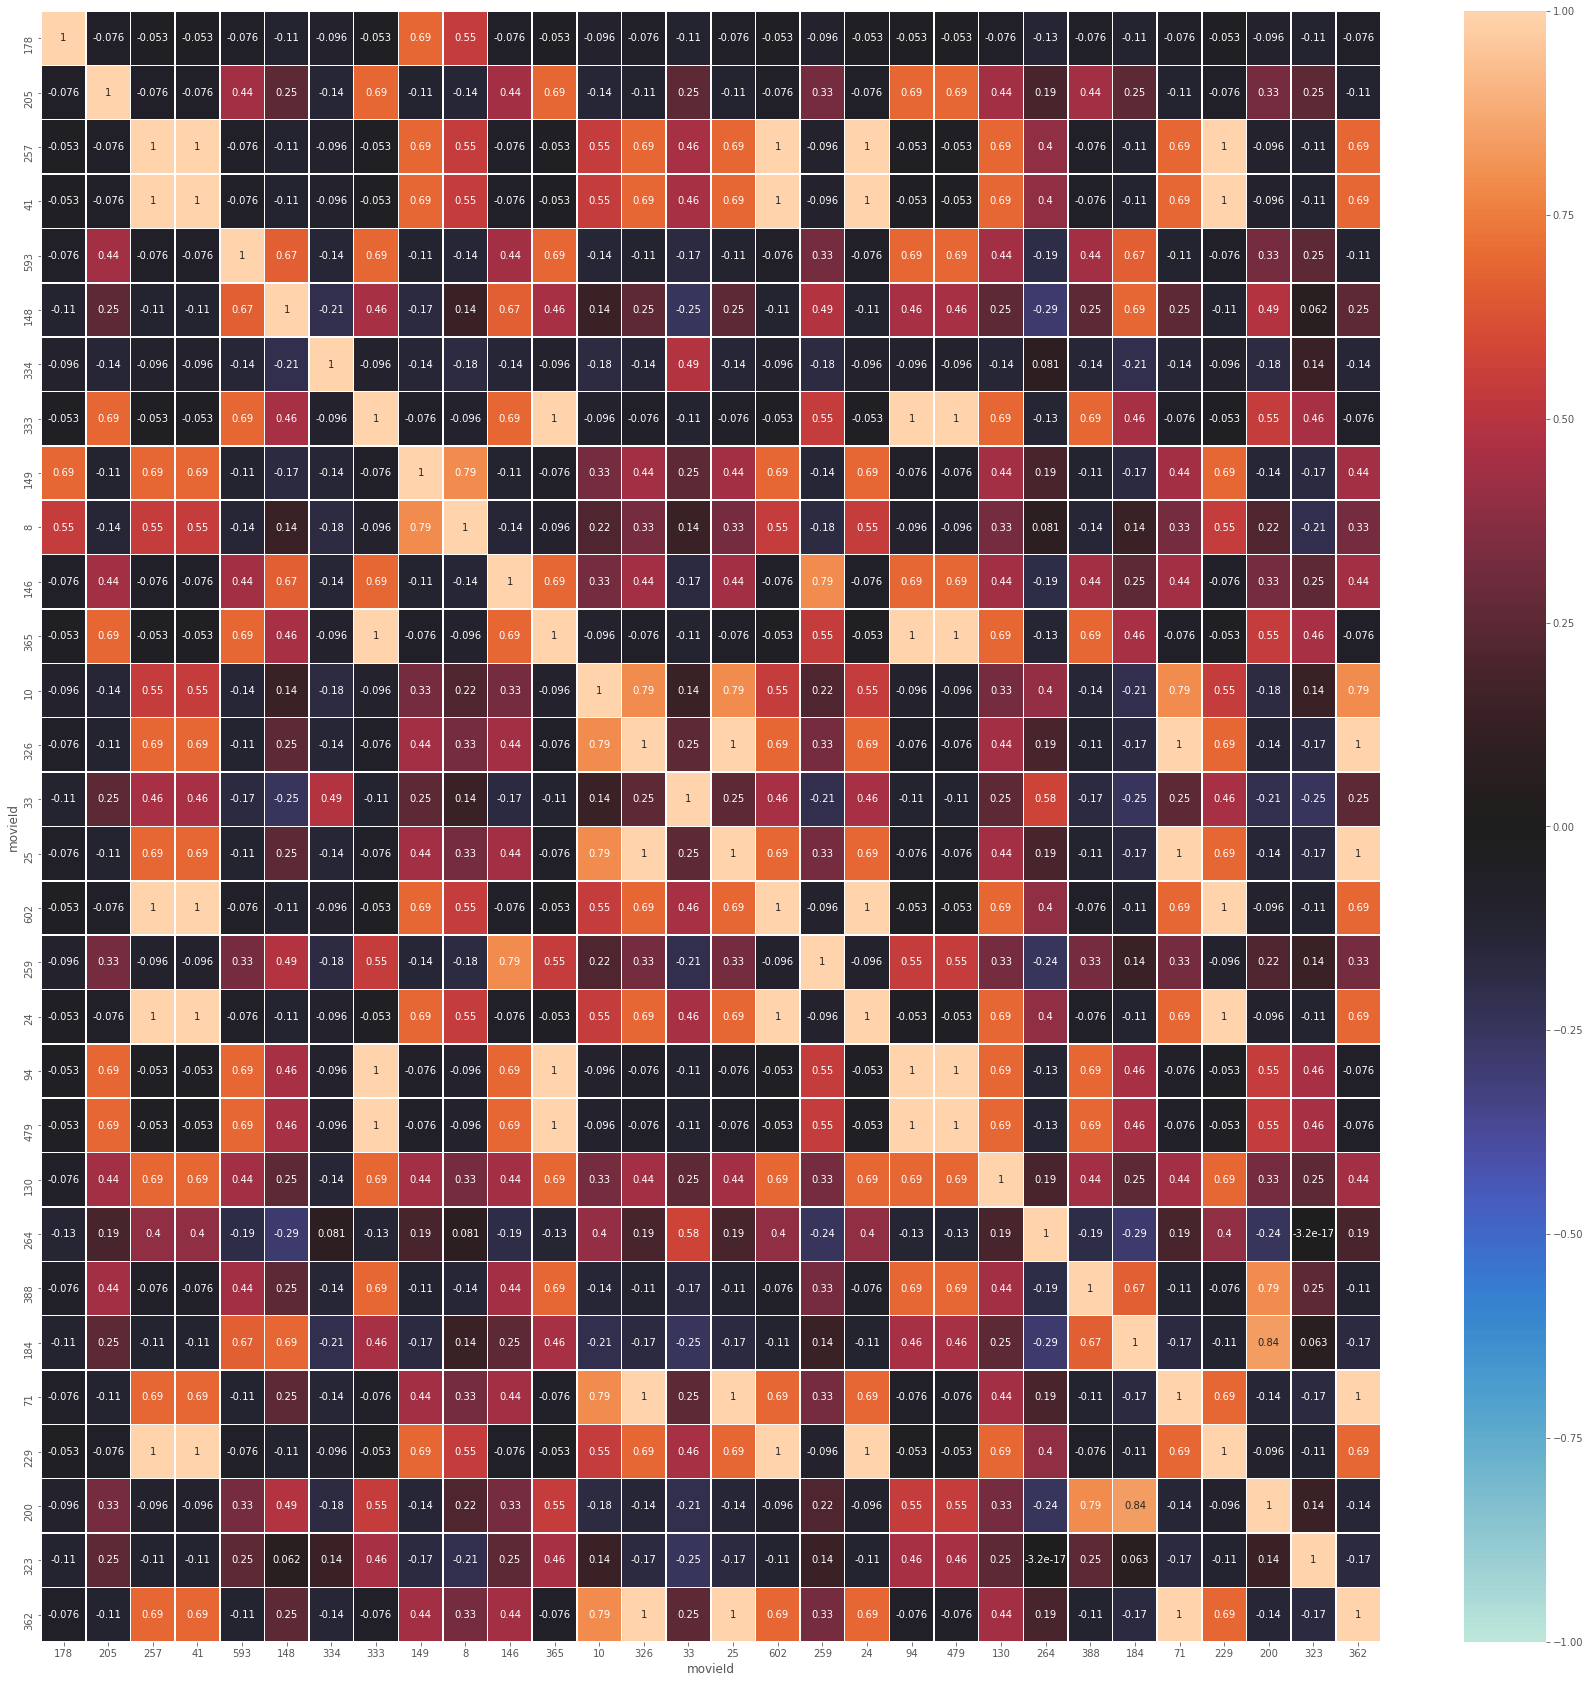

In [0]:
#  Pearson’s similarity()
pearson_genre_sim = random_genre_df.T.corr( method ='pearson' )
fig, ax = plt.subplots(figsize=(30,30))  
sns.heatmap(pearson_genre_sim, annot = True, vmin=-1, vmax=1, center= 0, linewidths=.5, ax=ax, xticklabels=random_mt.index, yticklabels=random_mt.index)

### แสดงรูปภาพ

In [0]:
# ตาราง user ที่มีความชอบตรงกันข้ามกันที่สุด 5 อันดับ Pearson’s similarity
pear_sim_genre, pear_opp_genre = display_top_sim(pearson_genre_sim, 'Pearson’s similarity')


*************************** Pearson’s similarity *************************** 
------ Top 5 Similarity ------
movieId  movieId
6465     2575       1.0
2257     96530      1.0
82527    2575       1.0
158398   57532      1.0
6465     6609       1.0
dtype: float64
------ Top 5 Diffence ------
movieId  movieId
33201    4232      -0.250000
4232     140850    -0.250000
         7118      -0.250000
92681    140850    -0.288675
33201    92681     -0.288675
dtype: float64


In [0]:
# รายการของ user ที่ให้ rating >= 3.0 ซึ่งสามารถแนะนำ movie ในรายการข้อ 3.2.1 ให้ได้
pear_sim_genre_df = pd.DataFrame(pear_sim_genre, columns=['similarity'])

# get movie id
sim_movies = set()
for t in list(pear_sim_genre_df.index) :
  sim_movies.add(t[0])
  sim_movies.add(t[1])
sim_movies = list(sim_movies)

pear_sim_genre_df

,,similarity
movieId,movieId,
6465,2575,1.0
2257,96530,1.0
82527,2575,1.0
158398,57532,1.0
6465,6609,1.0


In [0]:
user_rate3_df = user_rate_mt.loc[:, sim_movies]
user_rate3_df = user_rate3_df[user_rate3_df.gt(2.9)]
user_rate3_df.dropna(axis=0, how='all', inplace=True)     # drop row
user_rate3_df.dropna(axis=1, how='all', inplace=True)     # drop column
user_rate3_df

movieid,6465,2575,2257,6609,57532,158398,82527
userid,,,,,,,
51,NaN,NaN,NaN,NaN,3.5,NaN,NaN
66,NaN,NaN,4.0,NaN,NaN,NaN,NaN
89,NaN,NaN,NaN,NaN,NaN,5.0,NaN
198,NaN,3.0,NaN,NaN,NaN,NaN,NaN
275,NaN,5.0,NaN,NaN,NaN,NaN,NaN
305,NaN,NaN,NaN,NaN,3.5,NaN,NaN
387,3.0,NaN,NaN,NaN,NaN,NaN,NaN
414,NaN,3.0,NaN,NaN,NaN,NaN,NaN
448,NaN,NaN,NaN,NaN,NaN,NaN,4.0


In [0]:
reccomand_movie_col = list()
for idx, row in user_rate3_df.iterrows() :
  rec_movie = list()
  for col in user_rate3_df.columns:

    if pd.notnull(row[col]):

      for mID in pear_sim_genre_df.index:
        if col in mID :
          rec_movie.append(mID[0]) if mID.index(col) else rec_movie.append(mID[1])
  reccomand_movie_col.append(set(rec_movie))

df = pd.DataFrame(pd.Series(reccomand_movie_col), columns=['reccomand_movie'])
user_rate3_df['reccomand_movie'] = df['reccomand_movie'].values
user_rate3_df.fillna('-', inplace=True)
user_rate3_df

movieid,6465,2575,2257,6609,57532,158398,82527,reccomand_movie
userid,,,,,,,,
51,-,-,-,-,3.5,-,-,{158398}
66,-,-,4,-,-,-,-,{96530}
89,-,-,-,-,-,5,-,{57532}
198,-,3,-,-,-,-,-,"{6465, 82527}"
275,-,5,-,-,-,-,-,"{6465, 82527}"
305,-,-,-,-,3.5,-,-,{158398}
387,3,-,-,-,-,-,-,"{6609, 2575}"
414,-,3,-,-,-,-,-,"{6465, 82527}"
448,-,-,-,-,-,-,4,{2575}


# ตอนที่ 4: การจัดกลุ่ม User ที่มีความชอบคล้ายกันด้วยเทคนิค k-mean และ Gaussian Mixture

### สร้างข้อมูลความชอบของ user ตาม genre ของ movie ในรูปของ genre_rating_matrix

In [0]:
m_rate_user = user_rate_mt[user_rate_mt.gt(0)]
user_rate_mov_list = list()

for i in m_rate_user.index:
  df = pd.DataFrame(m_rate_user.loc[i]).T
  df.dropna(axis=1, inplace=True)
  user_rate_mov_list.append(df)

In [0]:
genre_rate_df_list = list()
genre_rate_df = genre_df.copy()
genre_rate_df.reset_index(drop=True, inplace=True)
genre_rate_df.set_index('movieId', inplace=True)
genre_rate_df = genre_rate_df.astype(float)

for i in range(len(user_rate_mov_list)) :
  df = genre_rate_df.copy()
  df = df.loc[user_rate_mov_list[i].columns]
  genre_rate_df_list.append(df)

In [0]:
for i, df in enumerate(genre_rate_df_list):
  for col in user_rate_mov_list[i].columns:
    genre_rate_df_list[i].loc[col].replace({
        1 : user_rate_mov_list[i][col].values[0],
        0 : np.nan}, inplace=True)

In [0]:
# find mean
mean_user_genre_list = list()
for i in range(len(genre_rate_df_list)):
  df = pd.DataFrame({ i : genre_rate_df_list[i].mean() }).T
  df.fillna(0, inplace=True)
  mean_user_genre_list.append(df)

In [0]:
genre_rating_mt = pd.concat(mean_user_genre_list)
genre_rating_mt.index.name = 'userId'
genre_rating_mt.columns.name = 'genres'
genre_rating_mt

genres,Romance,Mystery,Western,Children,Adventure,Thriller,Musical,Sci-Fi,Drama,Comedy,Fantasy,Documentary,Animation,Horror,IMAX,Crime,Action,Film-Noir,(no genres listed),War
userId,,,,,,,,,,,,,,,,,,,,
0,4.307692,4.166667,4.285714,4.547619,4.388235,4.145455,4.681818,4.225000,4.529412,4.277108,4.297872,0.000000,4.689655,3.470588,0.000000,4.355556,4.322222,5.0000,0.0,4.500000
1,4.500000,4.000000,3.500000,0.000000,4.166667,3.700000,0.000000,3.875000,3.882353,4.000000,0.000000,4.333333,0.000000,3.000000,3.750000,3.800000,3.954545,0.0000,0.0,4.500000
2,0.500000,5.000000,0.000000,0.500000,2.727273,4.142857,0.500000,4.200000,0.750000,1.000000,3.375000,0.000000,0.500000,4.687500,0.000000,0.500000,3.571429,0.0000,0.0,0.500000
3,3.379310,3.478261,3.800000,3.800000,3.655172,3.552632,4.000000,2.833333,3.483333,3.509615,3.684211,4.000000,4.000000,4.250000,3.000000,3.814815,3.320000,4.0000,0.0,3.571429
4,3.090909,4.000000,3.000000,4.111111,3.250000,3.555556,4.400000,2.500000,3.800000,3.466667,4.142857,0.000000,4.333333,3.000000,3.666667,3.833333,3.111111,0.0000,0.0,3.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,3.740845,3.791209,3.411765,3.448980,3.503401,3.525126,3.727273,3.556962,3.787966,3.565321,3.597938,3.800000,3.714286,3.346154,3.062500,3.654135,3.178808,3.8125,0.0,3.792308
606,3.517241,4.647059,4.000000,3.421053,3.466667,4.114754,3.600000,3.250000,4.012195,3.327273,3.571429,0.000000,3.333333,4.114286,5.000000,3.814815,3.722222,0.0000,0.0,4.166667
607,2.886792,3.550725,2.636364,2.460227,3.220994,3.536680,2.757576,3.296407,3.437500,2.736620,3.000000,3.000000,3.118182,3.319588,4.000000,3.613014,3.330325,3.7500,0.0,3.578947


###  สำหรับ K-mean model ให้กำหนดจำนวน n_cluster

In [0]:
t_df, test_df = train_test_split(genre_rating_mt, test_size=0.15, random_state=42)
train_df, valid_df = train_test_split(t_df, test_size=0.10, random_state=42)

print(train_df.shape)
print(test_df.shape)
print(valid_df.shape)

(466, 20)
(92, 20)
(52, 20)


In [0]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(train_df)
pred_y_train = kmeans.labels_
pred_y_train

array([2, 0, 0, 1, 2, 0, 0, 1, 1, 1, 2, 1, 2, 1, 0, 1, 1, 1, 1, 2, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 2, 1, 0, 0, 0, 0, 2, 0,
       2, 0, 1, 1, 2, 0, 2, 1, 1, 1, 0, 0, 1, 2, 1, 1, 2, 0, 1, 1, 2, 1,
       0, 0, 2, 0, 2, 0, 1, 2, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 2, 2, 2, 0, 2, 0, 0, 2, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0,
       2, 0, 2, 0, 0, 2, 1, 1, 1, 0, 2, 1, 0, 2, 0, 1, 0, 1, 0, 1, 0, 1,
       2, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 0, 2, 1, 1, 1, 2, 0, 1, 0, 2,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 2, 2, 1, 1, 0, 2, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 2, 1, 2, 1, 1, 0, 2, 0, 1, 1, 0, 2, 0, 1, 2, 1, 1,
       2, 0, 0, 2, 2, 1, 1, 0, 2, 0, 1, 0, 2, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 2, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 2, 0, 2, 2, 0, 0, 2,
       0, 0, 0, 1, 1, 0, 0, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 2, 1, 1, 0, 0, 1, 0, 1, 0, 2, 1, 2,
       1, 0, 0, 1, 2, 0, 1, 0, 1, 0, 0, 2, 1, 2, 1,

In [0]:
pred = kmeans.predict(valid_df)
pred

array([1, 0, 0, 1, 1, 2, 0, 1, 1, 1, 0, 1, 2, 2, 1, 0, 2, 1, 1, 1, 0, 2,
       0, 0, 0, 2, 1, 1, 1, 1, 1, 2, 0, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1,
       2, 2, 1, 0, 1, 2, 1, 2], dtype=int32)

In [0]:
kmean_center = kmeans.cluster_centers_
kmean_center

array([[3.67105171, 3.72285271, 3.35475403, 3.48088517, 3.62191391,
        3.63326894, 3.4152098 , 3.52314903, 3.81289582, 3.60686916,
        3.64808897, 2.99988469, 3.60973325, 3.39897305, 3.32857973,
        3.80658262, 3.54363135, 3.29049893, 0.23895028, 3.87890912],
       [3.7160325 , 3.6002179 , 2.19044593, 3.73430141, 3.73245975,
        3.64382985, 3.02271123, 3.59194416, 3.78881334, 3.64970097,
        3.61251461, 0.18918011, 3.75697228, 2.88848786, 3.33232887,
        3.72202825, 3.6182578 , 0.07526882, 0.11021505, 3.41225509],
       [3.35141816, 3.20818456, 1.8359135 , 1.74302532, 3.24825596,
        3.43897009, 1.23132704, 3.17579381, 3.59649457, 3.31572177,
        2.66280211, 0.76130351, 1.05646135, 2.57717984, 1.1854336 ,
        3.58026335, 3.3498698 , 1.07239057, 0.02693603, 2.83953127]])

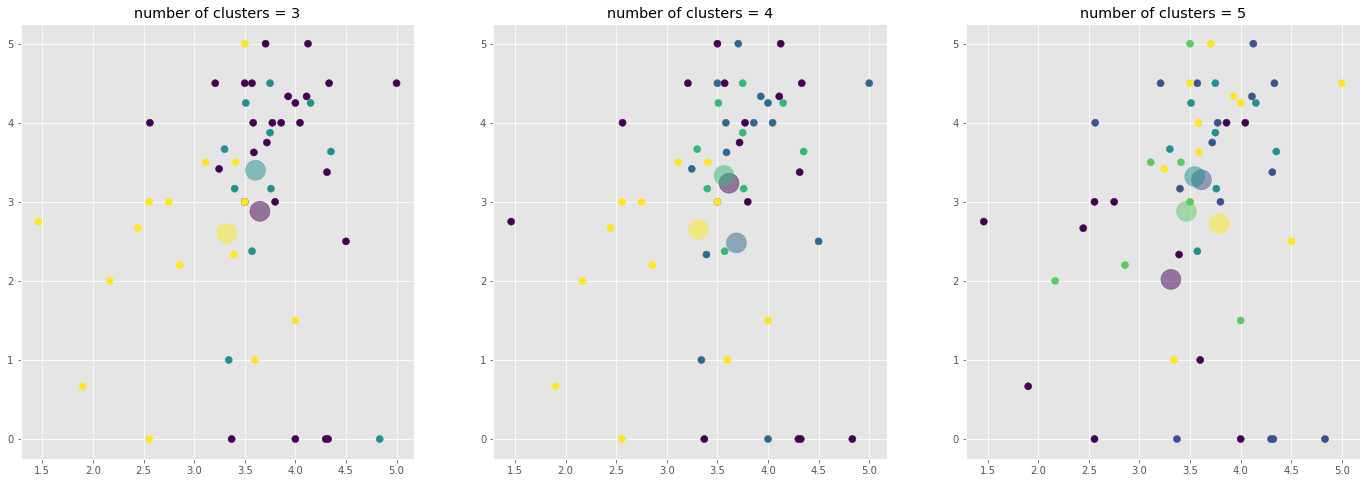

In [0]:
# แสดงรูปภาพผลลัพธ์ของการจัดกลุ่ม กำหนดให้เทียบรูปภาพอย่างน้อย n_cluster อย่างน้อย 3 ค่า
col_1 = 9
col_2 = 13



f = plt.figure(figsize=(24,8))
ax = f.add_subplot(131)
n_clusters = 3
kmeans = KMeans(n_clusters)
kmeans.fit(train_df)
y_kmeans = kmeans.predict(valid_df)
centers = kmeans.cluster_centers_
ax.scatter(valid_df.iloc[:, col_1], valid_df.iloc[:, col_2], c=y_kmeans, s=50, cmap='viridis')
ax.scatter(centers[:, col_1], centers[:, col_2], c=range(n_clusters),cmap='viridis', s=400, alpha=0.5);
ax.title.set_text('number of clusters = 3')

ax2 = f.add_subplot(132)
n_clusters = 4
kmeans = KMeans(n_clusters)
kmeans.fit(train_df)
y_kmeans = kmeans.predict(valid_df)
centers = kmeans.cluster_centers_
ax2.scatter(valid_df.iloc[:, col_1], valid_df.iloc[:, col_2], c=y_kmeans, s=50, cmap='viridis')
ax2.scatter(centers[:, col_1], centers[:, col_2],  c=range(n_clusters),cmap='viridis', s=400, alpha=0.5);
ax2.title.set_text('number of clusters = 4')

ax3 = f.add_subplot(133)
n_clusters = 5
kmeans = KMeans(n_clusters)
kmeans.fit(train_df)
y_kmeans = kmeans.predict(valid_df)
centers = kmeans.cluster_centers_
ax3.scatter(valid_df.iloc[:, col_1], valid_df.iloc[:, col_2], c=y_kmeans, s=50, cmap='viridis')
ax3.scatter(centers[:, col_1], centers[:, col_2],  c=range(n_clusters),cmap='viridis', s=400, alpha=0.5);
ax3.title.set_text('number of clusters = 5')

In [0]:
# for i in range(20):
#   for j in range(20):
#     col_1 = i
#     col_2 = j

#     plt.scatter(train_df[kmeans.labels_ == 0].iloc[:, col_1], train_df[kmeans.labels_ == 0].iloc[:, col_2], c='lightgreen', marker='o', edgecolor='black', s=30)
#     plt.scatter(train_df[kmeans.labels_ == 1].iloc[:, col_1], train_df[kmeans.labels_ == 1].iloc[:, col_2], c='lightblue', marker='o', edgecolor='black', s=30)
#     plt.scatter(train_df[kmeans.labels_ == 2].iloc[:, col_1], train_df[kmeans.labels_ == 2].iloc[:, col_2], c='red', marker='o', edgecolor='black', s=30)
#     plt.scatter(train_df[kmeans.labels_ == 3].iloc[:, col_1], train_df[kmeans.labels_ == 3].iloc[:, col_2], c='black', marker='o', edgecolor='black', s=30)
#     plt.scatter(train_df[kmeans.labels_ == 4].iloc[:, col_1], train_df[kmeans.labels_ == 4].iloc[:, col_2], c='yellow', marker='o', edgecolor='black', s=30)


#     plt.title(f'{i}, {j}')
#     plt.show()

###  สำหรับ Gaussian Mixture Model

In [0]:
import matplotlib as mpl
from scipy import linalg
from sklearn.mixture import GaussianMixture 
from matplotlib.patches import Ellipse
from pylab import *

In [0]:
gm = GaussianMixture(n_components=3, random_state=0).fit(train_df)

In [0]:
gm_wei = np.round(gm.weights_, 2)
gm_wei

array([0.36, 0.21, 0.43])

In [0]:
gm_mean = np.round(gm.means_, 2)
gm_mean

array([[3.61, 3.72, 3.3 , 3.54, 3.58, 3.59, 3.45, 3.52, 3.75, 3.55, 3.58,
        2.78, 3.7 , 3.45, 3.4 , 3.74, 3.52, 3.15, 0.36, 3.87],
       [3.59, 3.43, 2.14, 2.57, 3.4 , 3.55, 1.92, 3.27, 3.8 , 3.53, 3.19,
        1.96, 1.79, 2.74, 1.84, 3.71, 3.41, 1.96, 0.07, 3.26],
       [3.64, 3.5 , 2.17, 3.25, 3.68, 3.62, 2.68, 3.54, 3.75, 3.58, 3.41,
        0.  , 3.29, 2.8 , 2.94, 3.72, 3.6 , 0.  , 0.  , 3.24]])

In [0]:
gm_cov = np.round(gm.covariances_, 2)
gm_cov

array([[[ 0.24,  0.19,  0.07, ..., -0.03,  0.02,  0.18],
        [ 0.19,  0.25,  0.12, ...,  0.1 ,  0.01,  0.19],
        [ 0.07,  0.12,  1.66, ...,  0.27,  0.01,  0.07],
        ...,
        [-0.03,  0.1 ,  0.27, ...,  2.68, -0.21,  0.04],
        [ 0.02,  0.01,  0.01, ..., -0.21,  1.28, -0.02],
        [ 0.18,  0.19,  0.07, ...,  0.04, -0.02,  0.27]],

       [[ 0.61,  0.13,  0.18, ...,  0.14,  0.04,  0.17],
        [ 0.13,  1.34,  0.19, ...,  0.51,  0.05,  0.28],
        [ 0.18,  0.19,  3.81, ..., -0.18, -0.15,  1.  ],
        ...,
        [ 0.14,  0.51, -0.18, ...,  4.08, -0.14,  0.96],
        [ 0.04,  0.05, -0.15, ..., -0.14,  0.25, -0.24],
        [ 0.17,  0.28,  1.  , ...,  0.96, -0.24,  2.44]],

       [[ 0.36,  0.2 ,  0.07, ...,  0.  ,  0.  ,  0.23],
        [ 0.2 ,  1.68,  0.12, ...,  0.  ,  0.  ,  0.3 ],
        [ 0.07,  0.12,  3.49, ...,  0.  ,  0.  ,  0.93],
        ...,
        [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.

In [0]:
pred = gm.predict(valid_df)
pred

array([2, 0, 1, 2, 2, 1, 1, 2, 2, 2, 0, 2, 2, 1, 2, 1, 1, 2, 1, 2, 0, 1,
       0, 1, 0, 2, 0, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 0, 2, 0, 1, 2, 2, 2])

In [0]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, color='r', **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, 
                             angle,color=color, **kwargs))
        
def plot_gmm(gmm, X, col_id0, col_id1, n_components, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.predict(X)
    if label:
        ax.scatter(X.iloc[:, col_id0], X.iloc[:, col_id1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X.iloc[:, col_id0], X.iloc[:, col_id1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    
    cmap = cm.get_cmap('viridis', n_components)    
    color_list = []
    for i in range(cmap.N):
      rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
      color_list.append(matplotlib.colors.rgb2hex(rgb))
    for pos, covar, w, c  in zip(gmm.means_, gmm.covariances_, gmm.weights_,color_list):
        draw_ellipse(np.array([pos[col_1],pos[col_2]]), np.array([[covar[col_1][col_1],covar[col_1][col_2]],[covar[col_2][col_1],covar[col_2][col_2]]]), alpha=w * w_factor, color=c)

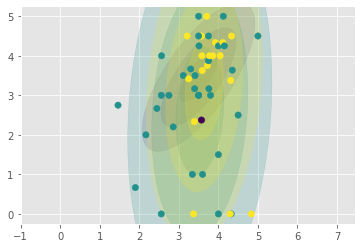

In [0]:
gmm = GaussianMixture(n_components=3, random_state=42, covariance_type='full').fit(train_df)
plot_gmm(gmm, valid_df, col_1, col_2, 3)

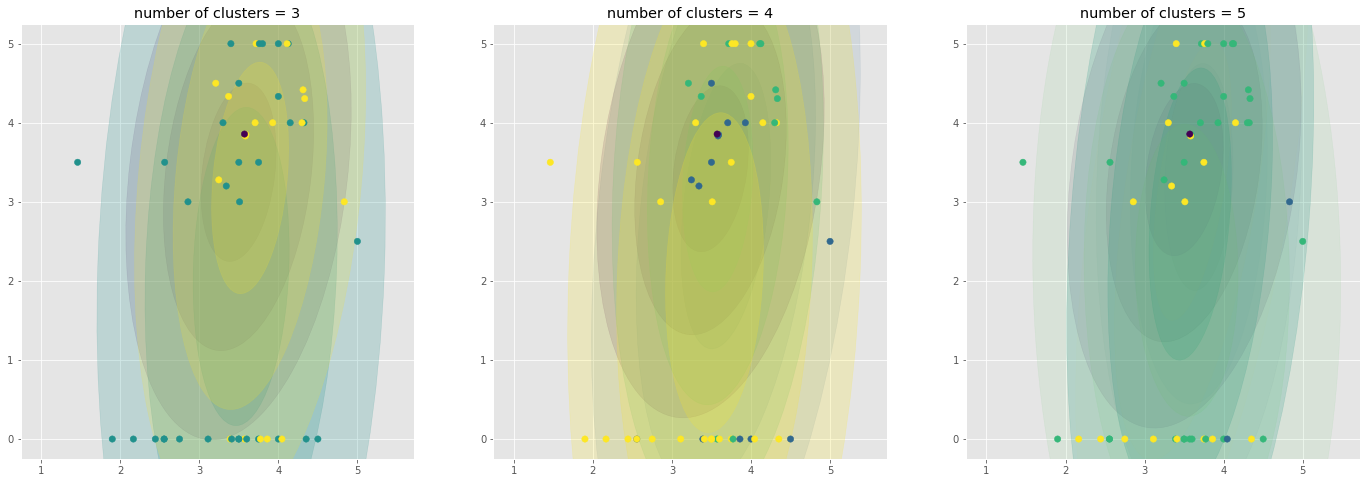

In [0]:
col_1 = 9
col_2 = 14


n_components = 3
f = plt.figure(figsize=(24,8))
ax = f.add_subplot(131)
gmm = GaussianMixture(n_components, random_state=42, covariance_type='full').fit(train_df)
plot_gmm(gmm, valid_df, col_1, col_2,n_components)
ax.title.set_text('number of clusters = 3')

ax2 = f.add_subplot(132)
n_components=4
gmm = GaussianMixture(n_components, random_state=42, covariance_type='full').fit(train_df)
plot_gmm(gmm, valid_df, col_1, col_2, n_components)
ax2.title.set_text('number of clusters = 4')

ax3 = f.add_subplot(133)
n_components = 5
gmm = GaussianMixture(n_components, random_state=42, covariance_type='full').fit(train_df)
plot_gmm(gmm, valid_df, col_1, col_2, n_components)
ax3.title.set_text('number of clusters = 5')